# Recipe Recommender System

---
### Problem Statement:

Give students personalised recipe recommendations such that they can make and eat great meals at home. Taking into account:
- Time available to cook
- Cuisences of interest
- Ingredients at hand

To solve this we made:

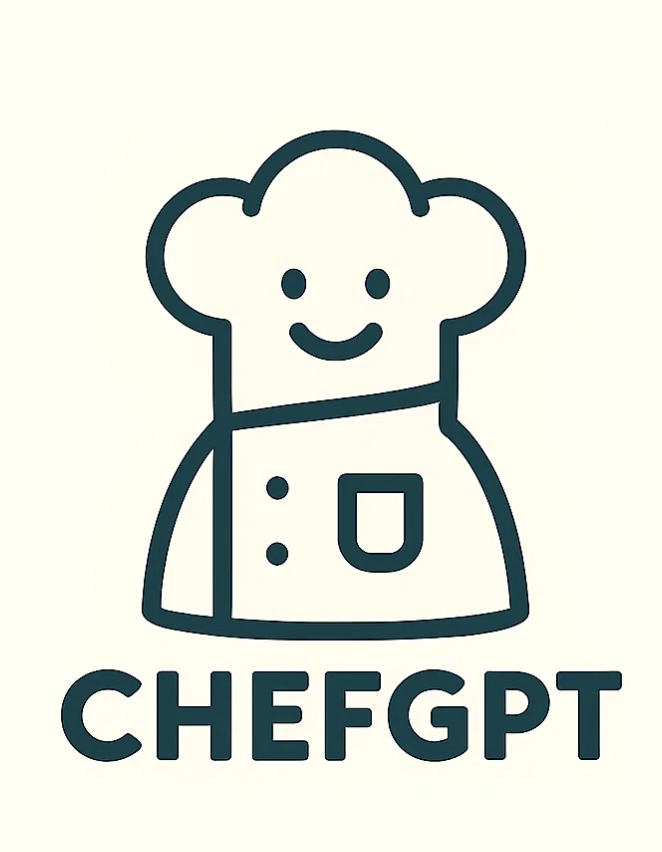

by the recommendation engine.

---
### Datasets:
Through the undertaking of thorough research we found the following real world datasets:

- [Food.com - Recipes and Reviews](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews?select=recipes.csv) - This dataset is our key foundational dataset:
    - Real world data that is very verbose and full of lots of features
- [Recipe Ingredients and Reviews Kaggle](https://www.kaggle.com/datasets/kanaryayi/recipe-ingredients-and-reviews/data) - This is one of our supplimentary datasets:
    - This data was very clean and essentially ready out of the box. It greatly suplemented the food.com dataset.
- [Recipe NLG](https://huggingface.co/datasets/mbien/recipe_nlg) - This is the second supplimentary dataset:
    - Supplementary dataset, it consists of a large number of recipes that we can add and use to recommend to the user for greater variety.

---
### Steps:

1. Data Exploration:
  - Looking at all the data we found and seeing which features we can extract for our task. This involved the thorough analysis of the data, where we found all features and flaws.
2. Data Pipeline:
  - The tash here was to clean and make the data useable for our recommendation methods. It was done in the following substeps:
    - Drop all unnecessary & null items rows in recipe data
    - Combine and format it
    - Create the following data for our methods:
      - List of key-values: User → (Recipe, Rating)
      - List of key-values: Recipe → (User, Rating)
      - Corpus of Recipe data:
        - Name
        - Description
        - Ingredients
        - Keywords + Categories
        - Total Cook Time
3. Content-Based Recommender System:
  - Given a list of recipes, we want to find other recipes that are similar to that list of recipes.
    - Input: List of recipes
    - Output: All recipes ranked from most similar to least similar.
  - How we calculate similarity:
    - Description: Sentence Embeddings using SBERT (cosine similarity)
    - Ingredients: Word Embeddings + Mean Pooling (cosine similarity)
    - Keywords/Categories: Word Embeddings + Mean Pooling (cosine similarity)
    - Total Cook Time: Z-Score (1 - min(abs(z1 - z2) / 6 and 1)
  - The final score is a linear combination of the above similarity calculations:
    - Ingredients and Keywords have higher weights as this is a key feature that we have identified.
    - Description and Cook Time have lower weights as in some cases the description was not entirely related to the recipes, there was a larger sense of variance as it was based on users inputting recipes.
  - For each of the 3 liked recipes from the user we want to get similarity scores and return top_k recipes (N.B. we have 3 * top_k recipes at the end)
4. User-Based Collaborative Filtering Method:
  - Build a recommendation system to suggest recipes to users based on ratings from similar users.
  - The task here was done in the following steps:
    1. Data Preparation: Split data: 80% train, 20% test
      - Map user_id and recipe_id to integer indices.
    2. Sparse Matrix Construction:
      - Create User–Item rating matrix using csr_matrix using the cleaned data available.
    3. Similarity Computation Compute cosine similarity between users (sparse).
    4. Rating Prediction Use top-k similar users
      - Normalize with mean-centering
      - Clip predictions to rating scale
    5. Model Evaluation
    6. Recommendation Generation
      - Recommend top-N recipes not rated by user
      - Rank by predicted rating
5. Item-Based Collaborative Filtering Method:
  - The task here was developed and implemented in the following steps:
      1. Preformed some further cleaning on the dataset by removing inactive users and rarely rated recipes to reduce cold-start noise.
      2. Built a user–recipe rating matrix to represent user preferences.
      3. Calculated item–item similarities using cosine similarity to find similar recipes.
      4. Evaluated the model with per-user train/test split (80/20) using metrics like Precision, Recall, Hit Rate, and Coverage.
6. Combined Model:
  - For the combined model, we aggregated the 3 models:
    1. Content Based Model
    2. Item-based Model
    3. User-based Model
  - There are 2 methods in doing so:
    1. Aggregated score per recipe
      - Each model returns a score for each recipe
      - Aggregated score would be a linear combination of scores from the three models
      - Final results would be the top-k highest-scoring recipes
    2. Concatenating results from each model:
      - Choosing some amount of recipes from each model, then aggregate the results (e.g. 4 from content-based, 3 from item-based and 3 from user-based)
      - This will give a mix of both similar recipes and new recipes for the users

### Getting past the **Cold Start Problem**:

In order to get past the cold start data we require the user to input 3 liked recipes and additonal features so we can create adequate user profiles out of the gate.

__The concept app:__

The full concept app is on the following link:
  - [Figma Design](https://www.figma.com/design/Z12gXW2PSA3M3Uoe8lCVrg/Untitled?node-id=0-1&t=6A7t4l00wbfIUJpZ-1)

The key pages we want to outline as as follows:
1. Signup
2. Set preferences
3. Get today's top 5 recommendations for the user




Signup Page:

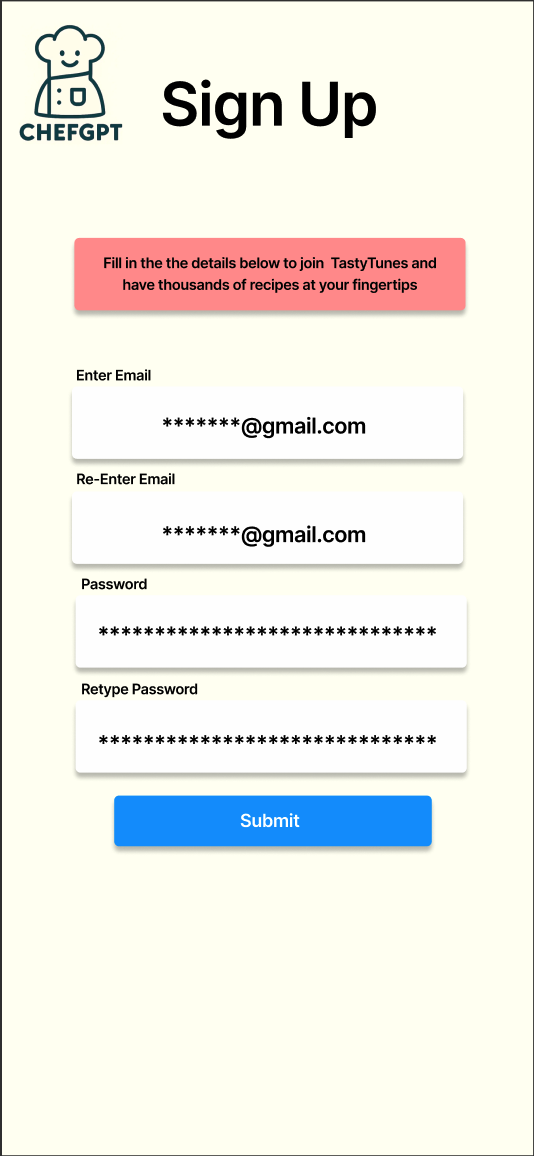

Set Preferences Page:

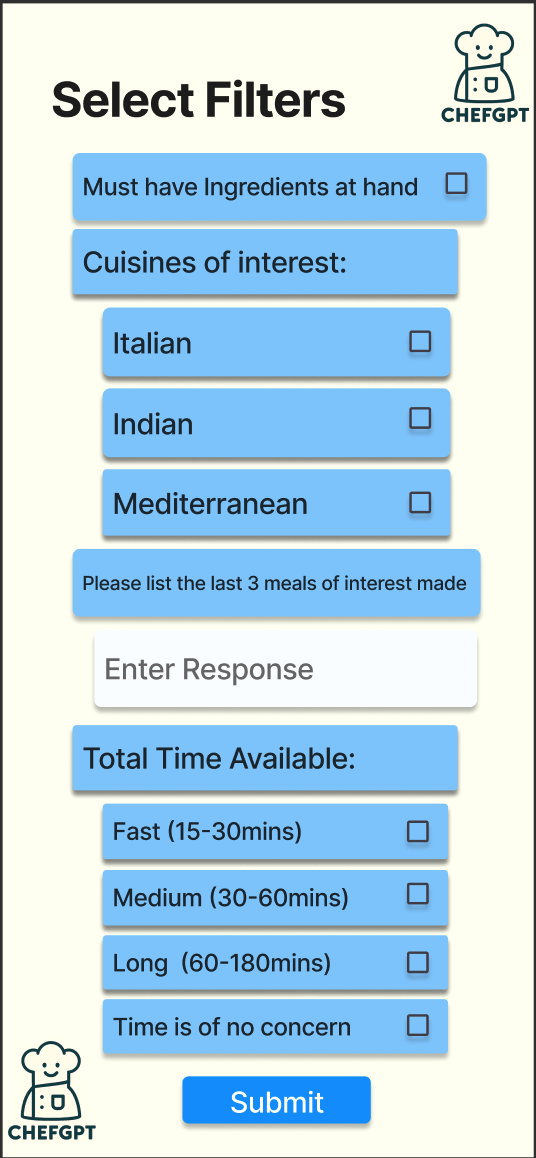

Recommedations Page:

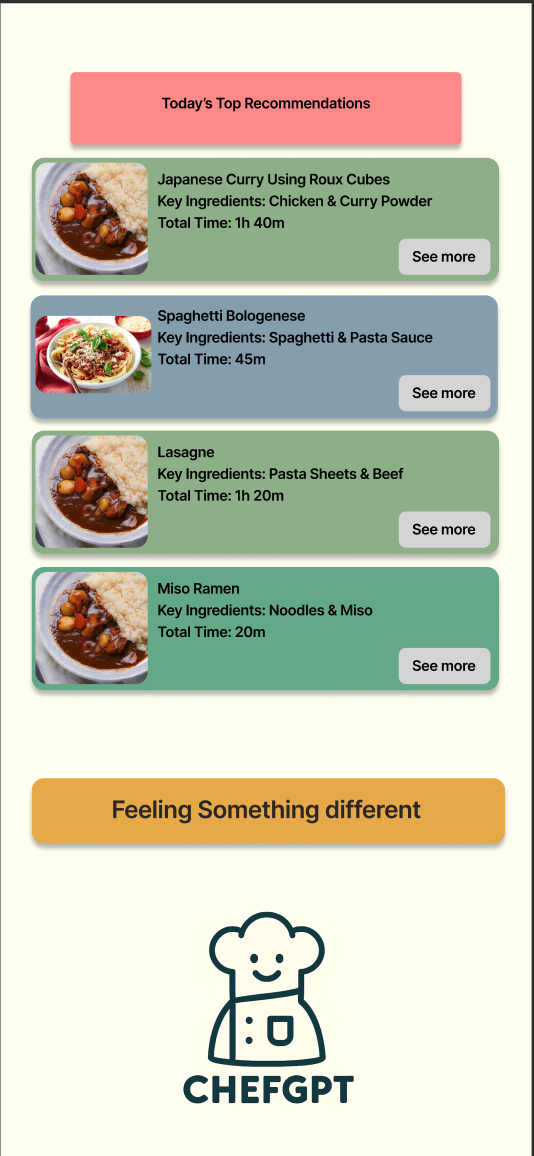

## Data Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Importing and Converting to DF -> Recipe Ingredients and Reviews (Kaggle) Dataset
RecipeIngredientsAndReviews_recipes_df = pd.read_csv('/content/drive/MyDrive/Recipe Recommender System/Raw Datasets/Recipe Ingredients and Reviews Dataset/clean_recipes.csv', sep=';')
RecipeIngredientsAndReviews_reviews_df = pd.read_csv('/content/drive/MyDrive/Recipe Recommender System/Raw Datasets/Recipe Ingredients and Reviews Dataset/clean_reviews.csv', sep=',')

# Importing and Converting to DF Food.com - Recipes and Reviews (Kaggle) Dataset
food_com_recipes_df = pd.read_csv('/content/drive/MyDrive/Recipe Recommender System/Raw Datasets/Food.com - Recipes and Reviews/recipes.csv', sep=',')
food_com_reviews_df = pd.read_csv('/content/drive/MyDrive/Recipe Recommender System/Raw Datasets/Food.com - Recipes and Reviews/reviews.csv', sep=',')

# Importing and Converting to DF Recipes NLG Dataset (HuggingFace)
recipes_nlg_df = pd.read_csv('/content/drive/MyDrive/Recipe Recommender System/Raw Datasets/Recipe NLG Dataset/full_dataset.csv', sep=',')


### food_com_recipes_df (Main Dataset 1/2)

In [ ]:
food_com_recipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

This is a large dataset and has a large set of features that we can use

In [ ]:
food_com_recipes_df.isnull().sum()

,0
RecipeId,0
Name,0
AuthorId,0
AuthorName,0
CookTime,82545
PrepTime,0
TotalTime,0
DatePublished,0
Description,5
Images,1


A draw back of this data set is that it has a lot of null values. Features that we wanted to use such as cook time, recipe category, key words, aggregated rating, review count have a large number of null values.

To work around this we need to clean the data where the vales are null especially where the rating is null. After that the dataset is much more useable and will fit our case better.

In [ ]:
food_com_recipes_df['AggregatedRating'].value_counts()

,count
AggregatedRating,
5.0,174516
4.0,42829
4.5,34330
3.0,9166
3.5,3978
2.0,2049
1.0,1677
2.5,673
1.5,76


The ratings seem rather skewed (1.5 .. 5) there is significantly more items rated 5. We may need to normalise the data before using it.

In [ ]:
food_com_recipes_df['Description'].head()

,Description
0,Make and share this Low-Fat Berry Blue Frozen ...
1,Make and share this Biryani recipe from Food.com.
2,This is from one of my first Good House Keepi...
3,This dish is best prepared a day in advance to...
4,Make and share this Cabbage Soup recipe from F...


We could extract features from the descriptions of eacvh recipe. Items that could be of interest to the user such as `Low-Fat` and so on.

In [ ]:
food_com_recipes_df['Keywords'].head()

,Keywords
0,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",..."
1,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",..."
2,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",..."
3,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We..."
4,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""..."


Very nice to have key words which we can use with the users preferences that we can set and update in the user profile vectors.

In [ ]:
food_com_recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


Key fields we want to consider:
- Name
- Total Time
- Description (After removing the null items from df)


#### food_com_recipes_df Review

This is a very nice, large, and comprehensive dataset where we have a lot of different data all labelled & relatively clean. Thus, we have chose this as our main data set for the project. In terms of current and future work this dataset has great features that we can use.

### food_com_reviews_df (Main Dataset 2/2)

In [ ]:
food_com_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   ReviewId       1401982 non-null  int64 
 1   RecipeId       1401982 non-null  int64 
 2   AuthorId       1401982 non-null  int64 
 3   AuthorName     1401982 non-null  object
 4   Rating         1401982 non-null  int64 
 5   Review         1401768 non-null  object
 6   DateSubmitted  1401982 non-null  object
 7   DateModified   1401982 non-null  object
dtypes: int64(4), object(4)
memory usage: 85.6+ MB


In [ ]:
food_com_reviews_df.isnull().sum()

,0
ReviewId,0
RecipeId,0
AuthorId,0
AuthorName,0
Rating,0
Review,214
DateSubmitted,0
DateModified,0


in some reviews there has been an ommission of the comment or textual review of the recipes. Overall, while we look at textual review to see if we can extract any feature data from it, for the most part we can clean and remove the reviews which have no comment as it is only 214 of the 1,401,982 total. There will still be 1,401,768 complete review data which we can use.


In [ ]:
food_com_reviews_df.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


From the textual review we can extract feature data where we can get additional sentiment, item features -> texture, specific taste, ...

Also look at the date modified, we can try prioritise more recent reviews as tastes and things change with time.

#### food_com_reviews_df Review

The data is very rich and clean, it has great features that can help with colaborative filtering and help fix our cold start problem.

### RecipeIngredientsAndReviews_recipes_df (Supplementary Dataset 1/2)

In [ ]:
RecipeIngredientsAndReviews_recipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12351 entries, 0 to 12350
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Recipe Name   12351 non-null  object
 1   Review Count  12351 non-null  object
 2   Recipe Photo  12351 non-null  object
 3   Author        12351 non-null  object
 4   Prepare Time  12351 non-null  object
 5   Cook Time     12351 non-null  object
 6   Total Time    12351 non-null  object
 7   Ingredients   12351 non-null  object
 8   Directions    12345 non-null  object
 9   RecipeID      12351 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 965.1+ KB


In [ ]:
RecipeIngredientsAndReviews_recipes_df.isnull().sum()

,0
Recipe Name,0
Review Count,0
Recipe Photo,0
Author,0
Prepare Time,0
Cook Time,0
Total Time,0
Ingredients,0
Directions,6
RecipeID,0


In [ ]:
RecipeIngredientsAndReviews_recipes_df.head()

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003
3,Apple Raisin Bread Recipe,39,https://images.media-allrecipes.com/userphotos...,Helen Hanson,15 m,1 h,1 h 15 m,"flour,baking powder,baking soda,salt,cinnamon,...",Preheat oven to 350 degrees F (175 degrees C)....,7006
4,Buttermilk Oatmeal Bread Recipe,41,https://images.media-allrecipes.com/userphotos...,Helen Hanson,10 m,1 h,1 h 40 m,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",Mix oats with buttermilk. Let stand for 1/2 h...,7007


#### RecipeIngredientsAndReviews_recipes_df Review
After looking at the Recipe Ingredients and Reviews (Kaggle) Dataset we can clearly see that it is clear it is cleaned and has nice labelled data built in. There are some features missing, we have number of reviews but we dont have the ratings or aggrigated ratings. The dataset is relative comprehensive where we can use ingredients to recommend recipes to items.

This dataset will be good for supplementing and getting a larger variety of items that we can recommend to the user based on liked ingredients.

Consider extraction of individual ingredients of recipes in the dataset so we can potentially use them in a set:
```
set_of_ingredients = set(User's used ingredients)
```
In the personalised profile vectors so that we can get more accurate recommendations.

### RecipeIngredientsAndReviews_reviews_df (Supplementary Dataset 2/2)

In [ ]:
RecipeIngredientsAndReviews_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563566 entries, 0 to 1563565
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   RecipeID   1563566 non-null  int64  
 1   profileID  1563566 non-null  int64  
 2   Rate       1563566 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 35.8 MB


In [ ]:
RecipeIngredientsAndReviews_reviews_df.isnull().sum()

,0
RecipeID,0
profileID,0
Rate,0


In [ ]:
RecipeIngredientsAndReviews_reviews_df.head()

,RecipeID,profileID,Rate
0,7000,675719,5.0
1,7000,1478626,5.0
2,7000,608663,5.0
3,7000,2785736,5.0
4,7000,594474,5.0


In [ ]:
RecipeIngredientsAndReviews_reviews_df['Rate'].value_counts()

,count
Rate,
5.0,1067458
4.0,327820
3.0,94686
2.0,39260
1.0,34342


#### RecipeIngredientsAndReviews_reviews_df Review

The file is extremely clean, and well structured. The main consideration for this is going to be very skewed data. There are significantly larger ratings that are given a rating of 5. We would potentially need to normalise this data before using it.

This data will be good to supplement the data we can use for colaborative filtering to help with our cold start problem.

### recipes_nlg_df (Supplementary Dataset 3)

In [ ]:
recipes_nlg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   title        object
 2   ingredients  object
 3   directions   object
 4   link         object
 5   source       object
 6   NER          object
dtypes: int64(1), object(6)
memory usage: 119.2+ MB


In [ ]:
recipes_nlg_df.isnull().sum()

,0
Unnamed: 0,0
title,1
ingredients,0
directions,0
link,0
source,0
NER,0


In [ ]:
recipes_nlg_df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


#### recipes_nlg_df Review

This is a very clean dataset that we can potentially use as an addition to get more variety of recommendations. It has only one null value item in the title column.

We can use the `ner` column to get key words for each recipe. This could help us get a large variety of recommendations.

## Data Pipeline

In [ ]:
import re

def parse_c_list(s):
    if pd.isna(s):
        return []
    return [item.strip() for item in re.findall(r'"([^"]+)"', s)]

food_com_recipes_df['keywords_list'] = food_com_recipes_df['Keywords'].apply(parse_c_list)
food_com_recipes_df['ingredient_quantities'] = food_com_recipes_df['RecipeIngredientQuantities'].apply(parse_c_list)
food_com_recipes_df['ingredient_parts'] = food_com_recipes_df['RecipeIngredientParts'].apply(parse_c_list)

food_com_recipes_df['keywords'] = food_com_recipes_df['keywords_list'].apply(lambda lst: ', '.join(lst))

food_com_recipes_df['ingredients_parsed'] = food_com_recipes_df.apply(
    lambda row: list(zip(row['ingredient_quantities'], row['ingredient_parts'])),
    axis=1
)

In [ ]:
food_com_recipes_df['keywords'].head()

,keywords
0,"Dessert, Low Protein, Low Cholesterol, Healthy..."
1,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A..."
2,"Low Protein, Low Cholesterol, Healthy, Summer,..."
3,"Beans, Vegetable, Low Cholesterol, Weeknight, ..."
4,"Low Protein, Vegan, Low Cholesterol, Healthy, ..."


In [ ]:
food_com_recipes_df['ingredients_parsed'].head()

,ingredients_parsed
0,"[(4, blueberries), (1/4, granulated sugar), (1..."
1,"[(1, saffron), (4, milk), (2, hot green chili ..."
2,"[(1 1/2, sugar), (1, lemons, rind of), (1 1/2,..."
3,"[(12, extra firm tofu), (1, eggplant), (2, zuc..."
4,"[(46, plain tomato juice), (4, cabbage), (1, o..."


In [ ]:
food_com_recipes_df['RecipeCategory'] = (
    food_com_recipes_df['RecipeCategory']
      .str.lower()
      .str.strip()
)

counts = food_com_recipes_df['RecipeCategory'].value_counts()
valid = counts[counts >= 100].index
food_com_recipes_df = food_com_recipes_df[
    food_com_recipes_df['RecipeCategory'].isin(valid)
].copy()

food_com_recipes_df['RecipeCategory'] = (
    food_com_recipes_df['RecipeCategory']
      .astype('category')
      .cat.remove_unused_categories()
)

In [ ]:
food_com_recipes_df['RecipeCategory'].value_counts()

,count
RecipeCategory,
dessert,62072
lunch/snacks,32586
one dish meal,31345
vegetable,27231
breakfast,21101
...,...
spring,117
vietnamese,113
chicken livers,112


In [ ]:
def parse_iso_duration(s):
    if pd.isna(s):
        return None
    s = str(s).upper().strip()
    m = re.match(r'PT(?:(?P<hours>\d+)H)?(?:(?P<minutes>\d+)M)?', s)
    if m:
        hours   = int(m.group('hours'))   if m.group('hours')   else 0
        minutes = int(m.group('minutes')) if m.group('minutes') else 0
        return hours * 60 + minutes
    try:
        return int(re.sub(r'\D', '', s))
    except ValueError:
        return None

for col in ['CookTime', 'PrepTime', 'TotalTime']:
    food_com_recipes_df[col] = food_com_recipes_df[col].apply(parse_iso_duration)

In [ ]:
food_com_recipes_df['TotalTime'].head()

,TotalTime
0,1485
1,265
2,35
3,1460
4,50


In [ ]:
RecipeIngredientsAndReviews_reviews_df.columns = (
    RecipeIngredientsAndReviews_reviews_df.columns
      .str.strip()
      .str.replace(' ', '')
      .str.lower()
)

clean_reviews_df = RecipeIngredientsAndReviews_reviews_df.rename(columns={
    'recipeid': 'recipeID',
    'profileid': 'userID',
    'rate': 'rating',
    'cleanedreviewtext': 'cleanedReviewText'
})

clean_reviews_df['dateModified'] = pd.NaT

In [ ]:
clean_reviews_df.head()

,recipeID,userID,rating,dateModified
0,7000,675719,5.0,NaT
1,7000,1478626,5.0,NaT
2,7000,608663,5.0,NaT
3,7000,2785736,5.0,NaT
4,7000,594474,5.0,NaT


In [ ]:
food_com_reviews_df.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [ ]:
food_com_reviews_df.columns

Index(['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review',
       'DateSubmitted', 'DateModified'],
      dtype='object')

In [ ]:
food_com_reviews_df.columns = (
    food_com_reviews_df.columns
      .str.strip()
      .str.replace(' ', '')
      .str.lower()
)

raw = food_com_reviews_df[['recipeid','authorid','rating','review','datemodified']]
raw_latest = (
    raw
      .sort_values('datemodified')
      .drop_duplicates(subset=['recipeid','authorid'], keep='last')
      .assign(source='food_com_reviews', cleanedText=lambda df: df['review'])
      [['recipeid','authorid','rating','datemodified','source','cleanedText']]
)

pairs_raw = set(zip(raw_latest['recipeid'], raw_latest['authorid']))
clean_only = clean_reviews_df[
    ~clean_reviews_df.set_index(['recipeID','userID']).index.isin(pairs_raw)
].copy()

clean_only = (
    clean_only
      .assign(source='RecipeIngredientsAndReviews', cleanedText='No Text Review')
      [['recipeID','userID','rating','dateModified','source','cleanedText']]
)

all_reviews = pd.concat([raw_latest, clean_only], ignore_index=True)

In [ ]:
corpus_df = (
    food_com_recipes_df
      .assign(Category_Keywords=lambda df:
          df['RecipeCategory'].str.strip() + ' ' +
          df['keywords'].fillna('')
      )
)[[
    'RecipeId','Name','RecipeCategory','Category_Keywords','Description','TotalTime','AggregatedRating','ReviewCount','ingredient_parts'
]]

In [ ]:
corpus_df.head()

,RecipeId,Name,RecipeCategory,Category_Keywords,Description,TotalTime,AggregatedRating,ReviewCount,ingredient_parts
0,38,Low-Fat Berry Blue Frozen Dessert,frozen desserts,"frozen desserts Dessert, Low Protein, Low Chol...",Make and share this Low-Fat Berry Blue Frozen ...,1485,4.5,4.0,"[blueberries, granulated sugar, vanilla yogurt..."
1,39,Biryani,chicken breast,"chicken breast Chicken Thigh & Leg, Chicken, P...",Make and share this Biryani recipe from Food.com.,265,3.0,1.0,"[saffron, milk, hot green chili peppers, onion..."
2,40,Best Lemonade,beverages,"beverages Low Protein, Low Cholesterol, Health...",This is from one of my first Good House Keepi...,35,4.5,10.0,"[sugar, lemons, rind of, lemon, zest of, fresh..."
3,41,Carina's Tofu-Vegetable Kebabs,soy/tofu,"soy/tofu Beans, Vegetable, Low Cholesterol, We...",This dish is best prepared a day in advance to...,1460,4.5,2.0,"[extra firm tofu, eggplant, zucchini, mushroom..."
4,42,Cabbage Soup,vegetable,"vegetable Low Protein, Vegan, Low Cholesterol,...",Make and share this Cabbage Soup recipe from F...,50,4.5,11.0,"[plain tomato juice, cabbage, onion, carrots, ..."


In [ ]:
import nltk

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

snowball = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Final Preprocessing Function
    @param text: text to preprocess
    """
    text = re.sub(r"[^\w\s']", '', text) # remove all special characters
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [snowball.stem(word) for word in tokens]
    return ' '.join(tokens)

In [ ]:
corpus_df['Category_Keywords'] = corpus_df['Category_Keywords'].apply(preprocess_text)
corpus_df['Description'] = corpus_df['Description'].fillna('').apply(preprocess_text)

In [ ]:
corpus_df.head()

,RecipeId,Name,RecipeCategory,Category_Keywords,Description,TotalTime,AggregatedRating,ReviewCount,ingredient_parts
0,38,Low-Fat Berry Blue Frozen Dessert,frozen desserts,frozen dessert dessert low protein low cholest...,make share lowfat berri blue frozen dessert re...,1485,4.5,4.0,"[blueberries, granulated sugar, vanilla yogurt..."
1,39,Biryani,chicken breast,chicken breast chicken thigh leg chicken poult...,make share biryani recip foodcom,265,3.0,1.0,"[saffron, milk, hot green chili peppers, onion..."
2,40,Best Lemonade,beverages,beverag low protein low cholesterol healthi su...,one first good hous keep cookbook must use zes...,35,4.5,10.0,"[sugar, lemons, rind of, lemon, zest of, fresh..."
3,41,Carina's Tofu-Vegetable Kebabs,soy/tofu,soytofu bean veget low cholesterol weeknight b...,dish best prepar day advanc allow ingredi soak...,1460,4.5,2.0,"[extra firm tofu, eggplant, zucchini, mushroom..."
4,42,Cabbage Soup,vegetable,veget low protein vegan low cholesterol health...,make share cabbag soup recip foodcom,50,4.5,11.0,"[plain tomato juice, cabbage, onion, carrots, ..."


In [ ]:
corpus_df['Name'] = (
    corpus_df['Name']
      .str.lower()
      .str.strip()
)

In [ ]:
corpus_df.head()

,RecipeId,Name,RecipeCategory,Category_Keywords,Description,TotalTime,AggregatedRating,ReviewCount,ingredient_parts
0,38,low-fat berry blue frozen dessert,frozen desserts,frozen dessert dessert low protein low cholest...,make share lowfat berri blue frozen dessert re...,1485,4.5,4.0,"[blueberries, granulated sugar, vanilla yogurt..."
1,39,biryani,chicken breast,chicken breast chicken thigh leg chicken poult...,make share biryani recip foodcom,265,3.0,1.0,"[saffron, milk, hot green chili peppers, onion..."
2,40,best lemonade,beverages,beverag low protein low cholesterol healthi su...,one first good hous keep cookbook must use zes...,35,4.5,10.0,"[sugar, lemons, rind of, lemon, zest of, fresh..."
3,41,carina's tofu-vegetable kebabs,soy/tofu,soytofu bean veget low cholesterol weeknight b...,dish best prepar day advanc allow ingredi soak...,1460,4.5,2.0,"[extra firm tofu, eggplant, zucchini, mushroom..."
4,42,cabbage soup,vegetable,veget low protein vegan low cholesterol health...,make share cabbag soup recip foodcom,50,4.5,11.0,"[plain tomato juice, cabbage, onion, carrots, ..."


In [ ]:
corpus_df.drop(columns='Description').drop(columns='RecipeCategory').to_csv(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/recipe_corpus.csv', index=False
)

corpus_df.to_csv(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/recipe_allCol_corpus.csv', index=False
)

In [ ]:
# user‑based CF: key = userID, value = list of (recipeID, rating)
user_ratings = (
    all_reviews
      .groupby('userID')
      .apply(lambda df: list(zip(df['recipeID'], df['rating'])))
      .to_dict()
)

# item‑based CF: key = recipeID, value = list of (userID, rating)
item_ratings = (
    all_reviews
      .groupby('recipeID')
      .apply(lambda df: list(zip(df['userID'], df['rating'])))
      .to_dict()
)

/tmp/ipython-input-827138707.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(zip(df['recipeID'], df['rating'])))
/tmp/ipython-input-827138707.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: list(zip(df['userID'], df['rating'])))


In [ ]:
import json

with open('/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/user_based_cf_data.json', 'w') as f:
    json.dump({str(k): v for k, v in user_ratings.items()}, f)

with open('/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/item_based_cf_data.json', 'w') as f:
    json.dump({str(k): v for k, v in item_ratings.items()}, f)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect   = TfidfVectorizer(max_features=10_000, stop_words='english', ngram_range=(1,2))

corpus_df.assign(Description_Category_Keywords=lambda df:
          df['RecipeCategory'].str.strip() + ' ' +
          df['Description'].fillna('')
)

tfidf_matrix = tfidf_vect.fit_transform(corpus_df['RecipeCategory'])

In [ ]:
meta = corpus_df[[
    'AggregatedRating','ReviewCount'
]].copy()

for col in meta.columns:
    # convert any erroring strings to NaN
    meta[col] = pd.to_numeric(meta[col], errors='coerce')
    mn, mx = meta[col].min(), meta[col].max()
    if pd.isnull(mn) or pd.isnull(mx) or mx == mn:
        # constant or missing, set to zero
        meta[col] = 0.0
    else:
        meta[col] = (meta[col] - mn) / (mx - mn)

# One‑hot encode
cat_ohe = pd.get_dummies(corpus_df['RecipeCategory'])

recipe_meta = pd.concat([
    corpus_df[['RecipeId','Name']].reset_index(drop=True),
    meta.reset_index(drop=True),
    cat_ohe.reset_index(drop=True)
], axis=1)

In [ ]:
recipe_meta.head()

,RecipeId,Name,AggregatedRating,ReviewCount,< 15 mins,< 30 mins,< 4 hours,< 60 mins,african,apple,...,very low carbs,vietnamese,weeknight,white rice,whole chicken,whole turkey,wild game,winter,yam/sweet potato,yeast breads
0,38,low-fat berry blue frozen dessert,0.875,0.000980,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,39,biryani,0.500,0.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,40,best lemonade,0.875,0.002939,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,41,carina's tofu-vegetable kebabs,0.875,0.000327,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,42,cabbage soup,0.875,0.003266,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
recipe_meta.shape

(518133, 180)

In [ ]:
from scipy.sparse import coo_matrix

user_ids = all_reviews['userID'].unique()
item_ids = all_reviews['recipeID'].unique()
user_map = {u: i for i, u in enumerate(user_ids)}
item_map = {r: i for i, r in enumerate(item_ids)}

rows = all_reviews['userID'].map(user_map)
cols = all_reviews['recipeID'].map(item_map)
data = all_reviews['rating']

user_item_matrix = coo_matrix((data, (rows, cols)), shape=(len(user_ids), len(item_ids)))

In [ ]:
import scipy.sparse, pickle, json

# TF‑IDF
scipy.sparse.save_npz(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/tfidf_recipes.npz',
    tfidf_matrix
)
with open(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/tfidf_vectorizer.pkl',
    'wb'
) as f:
    pickle.dump(tfidf_vect, f)

# metadata
recipe_meta.to_csv(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/recipe_meta.csv',
    index=False
)

# collaborative matrix
scipy.sparse.save_npz(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/user_item_matrix.npz',
    user_item_matrix.tocsr()
)

# map keys -> strings so JSON can serialize them
user_map_str = {str(k): int(v) for k, v in user_map.items()}
item_map_str = {str(k): int(v) for k, v in item_map.items()}

with open(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/user_map.json',
    'w'
) as f:
    json.dump(user_map_str, f)

with open(
    '/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/item_map.json',
    'w'
) as f:
    json.dump(item_map_str, f)

## Content-based Recommender System

#### Overview

For our content-based model, we want to be able to find similar recipes, given some recipes the user liked before. This is essential and will be the backbone of our hybrid recommender system, since content-based gives similar and reliable results, according to user historical data.

##### Input
The input for this model would be three recipes the user liked before.

Now, in order to deal with cold start problems, initially when user signs up, they are required to choose three recipes they like before they can start using the app. As they use the app, they would view and like recipes as they go. This model imitates the UI behaviour by choosing the three most recent liked recipes as inputs.

##### Output
The output of this model would be the top K recipes with the highest similarity scores. The paramters that affect similarity scores are description, ingredients, keywords and total cook time. More details are provided below.

#### Available Data
Here is a list of data we use for the content-based part:
1. The name of the recipe. This is not actually as a parameter. It is more so for qualitative evaluation.

2. The description of the recipe. The description would be converted into a vector embedding using a lightweight sentence transformer ('all-MiniLM-L6-v2'), and we can use cosine similarity later on to get similarity.

3. The ingredients of the recipe. We hypothesise (and it makes intuitive sense) that recipes with similar ingredients are similar, hence the ingredients will be used as a paramter.

4. The keywords and categories of the recipe. This is included for very similar reasons as the ingredients list.

5. Total Cook Time of the recipe. We hypothesise that there are at least some correlation with cook time. For example, a busy person would be very likely to keep picking recipes with a low cook time.

Here is an example of what the data looks like. We have chosen the recipe "low-fat berry blue frozen dessert" as the example here.

- Name: Low-fat berry blue frozen dessert
- Description: make share lowfat berri blue frozen dessert recipe foodcom
- Ingredients: blueberries, granulated sugar, vanilla yogurt, lemon juice
- Keywords/Categories: frozen dessert, low protein, low cholesterol, healthy, summer, weeknight, freezer, easy
- Total Cook Time (in minutes): 1485

#### Method

Our content-based model is hybrid itself as well. This choice is mainly to make sure that we are utilising all the available data mentioned above to its full extent. Here are the four different parts of the model:

1. Description: As mentioned before, we convert each recipe description into a vector embedding. This allows us to then use cosine similarity to quantify similarity.

2. Ingredients: For each ingredient, we use a word embedding model to map the ingredient into its semantic vector, then we use mean pooling to get the average of all the ingredients for that recipe into a vector embedding that represents all the ingredients as a whole. Then, again we use cosine similarity to calculate similarity. Note that we have chosen a transformer (as opposed to one-hot vector embedding) because a transformer can capture semantic meaning as well. For example, it can capture the similarity between categories "frozen dessert" and "dessert", while one-hot embeddings cannot.

3. Keywords/Categories: This uses the exact same technique as ingredients - we embed each keyword and then mean pool them together.

4. Total Cook Time: We first find the standard deviation and variance of all the cook times. This allows us to get the z-scores for each cook time, and we can use the following formula to calculate the similarity between two cook times: `z_score_similarity = 1 - min(abs(z_score_1 - z_score_2) / 6, 1)`. Essentially, anything outside of 3 standard deviations would be outliers, so we max out the difference at 1. Then, the bigger the difference between the z-scores, the lower the similarity score for z-score.

N.B. For the cosine similarity score, we have normalised it from the range [-1, 1] to [0, 1] for better score calcaultion.

So, for each of the sub-models we obtain a score from 0 to 1, which then allows us to assign weights for each part. Here are the weights:

1. Description = 0.1. We have given it a lower weight, since some of the descriptions are quite strange. If you refer back to the example we've shown, you can see that it doesn't really relate to the recipe that much.

2. Ingredients = 0.4. It makes sense that the more similar the ingredients, the more similar the recipes are. Hence, we have given this part more weight.

3. Keywords = 0.45. Keywords are arguably the most relevant parameter for this model. It directly correlates to how similar two recipes are. For example, if they are both Italian cuisine, then it makes sense that they will be quite similar. Hence, we have given this part the most weight.

4. Total Cook Time = 0.05. As mentioned before, there could be some correlation with cook time, but the effect should be a lot less than ingredients and keywords, hence a relatively low weight used here.

After that, we calculate the similarity scores for every recipe against the three user-liked recipes. This would allow us to get the top M most similar recipes from each liked recipe, where `K = 3M`. Finally, we can get the top K recipes for the user with our content-based model by combining the chosen recipes together.

#### Word Embedding vs. One-hot Vector Embedding

To show the rationale behind our choice here, we have done some qualitative analysis on the differences between the two models. Here are the results against the recipe "low-fat berry blue frozen dessert":

| One-Hot Embeddings                       | Word Embeddings                         |
|------------------------------------------|------------------------------------------|
| almond paste                             | almond paste                             |
| blueberry pancake syrup                  | blueberry buttertarts                    |
| caramel apple milkshakes                 | blueberry dessert                        |
| brownie pudding                          | cheesecake cupcakes with blueberries     |
| brown bag apple salad                    | brown bag apple salad                    |
| black coffee barbecue sauce              | blueberry pancake syrup                  |
| cherry sandwich maker snack              | caramel apple milkshakes                 |
| california chilled salsa                 | california chilled salsa                 |
| best lemonade                            | best lemonade                            |
| black bean, corn, and tomato salad       | brownie pudding                          |
| blueberry buttertarts                    | black bean, corn, and tomato salad       |
| champagne punch                          | black coffee barbecue sauce              |
| borscht                                  | almond joy cake                          |
| cafe cappuccino                          | blueberry scones                         |
| caputo's halibut with mint and balsamic vinegar | cafe cappuccino                          |
| black bean salsa                         | cherry sandwich maker snack              |
| cabbage soup                             | butterscotch apple dumpling              |
| borsch                                   | black bean salsa                         |
| almond joy cake                          | alfredo sauce                            |
| blue stuffed mushrooms                   | carrot ginger biscuits                   |

As we can see, word embeddings have a lot more blueberry/berry recipes compared to one-hot embedding. We are also seeing more desserts for word embedding results (e.g. brownie pudding and almond joy cake), as opposed to the non-desserts in one-hot embeddings (e.g. cabbage soup, blue stuffed mushrooms).





In [ ]:
%pip install sentence_transformers

In [ ]:
import pandas as pd
import numpy as np
import ast

content_based_df = pd.read_csv('/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/Content-Based Data/recipe_allCol_corpus.csv')

# String lists into actual Python lists
content_based_df["ingredient_parts"] = content_based_df["ingredient_parts"].apply(ast.literal_eval)
content_based_df["Category_Keywords"] = content_based_df["Category_Keywords"].apply(lambda x: x.split())

content_based_df[:1]

,RecipeId,Name,RecipeCategory,Category_Keywords,Description,TotalTime,AggregatedRating,ReviewCount,ingredient_parts
0,38,low-fat berry blue frozen dessert,frozen desserts,"[frozen, dessert, dessert, low, protein, low, ...",make share lowfat berri blue frozen dessert re...,1485,4.5,4.0,"[blueberries, granulated sugar, vanilla yogurt..."


In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Helper Functions for vector embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Added cache for word
print(f'Number of unique ingredients: {len(set(word for words in content_based_df["ingredient_parts"] for word in words))}')
print(f'Number of unique keywords: {len(set(word for words in content_based_df["Category_Keywords"] for word in words))}')

token_to_vec_cache = {}

def get_embedding(word):
    if word not in token_to_vec_cache:
        token_to_vec_cache[word] = model.encode(word, convert_to_tensor=False)
    return token_to_vec_cache[word]


def mean_pool_embedding(words):
    vecs = [get_embedding(w) for w in words]
    if not vecs:
        return np.zeros(model.get_sentence_embedding_dimension())
    return np.mean(vecs, axis=0)

Number of unique ingredients: 7350
Number of unique keywords: 327


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Description
desc_embeddings = list(model.encode(content_based_df['Description'].tolist()))

In [ ]:
# Word Embeddings + Mean Pooling for ingredients and keywords
ingredient_vecs = content_based_df['ingredient_parts'].apply(mean_pool_embedding)
keyword_vecs = content_based_df['Category_Keywords'].apply(mean_pool_embedding)

In [ ]:
# z-scores for total time
scaler = StandardScaler()
z_scores = scaler.fit_transform(content_based_df[['TotalTime']]).flatten()

In [ ]:
db_content_based_df = pd.DataFrame({
    'recipe_id': content_based_df['RecipeId'],
    'name': content_based_df['Name'],
    'description': desc_embeddings,
    'ingredients': list(ingredient_vecs),
    'keywords': list(keyword_vecs),
    'time': z_scores
})

In [ ]:
db_content_based_df[:1]

In [ ]:
# Distance functions
# Note that for both distance functions, they return a score intsead of the actual distance

# Input: a, b are one-hot vectors
def jaccard_score(a, b):
    a = np.array(a)
    b = np.array(b)
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return intersection / union if union != 0 else 0.0

# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim_score(a, b):
    a = np.array(a).reshape(1, -1)
    b = np.array(b).reshape(1, -1)
    return (cosine_similarity(a, b)[0][0] + 1) / 2  # Normalised

# Z-score
def z_score_score(x, y):
    return 1 - min(1, abs(x - y) / 6)   # Anything outside 3 sd are outliers so we cut

# Example Usage
a = [1, 0, 0]
b = [1, 1, 1]

print(f'Jaccard Score Example: {jaccard_score(a, b)}')
print(f'Cosine Similarity Score Example: {cos_sim_score(a, b)}')

In [ ]:
# Getting similarity scores from input to all recipes
# Ideally, we keep all the scores for each section from 0 to 1

# Weights
desc_weight = 0.1
ingr_weight = 0.4
keywords_weight = 0.45
time_weight = 0.05

# Input: recipe_id
# Output: An array of recipe, similarity score pairs sorted in descending order
sim_scores_cache = {}

def get_similarity_scores(recipe_id):
    if recipe_id in sim_scores_cache:
        return sim_scores_cache[recipe_id]

    res = []

    target = db_content_based_df[db_content_based_df["recipe_id"] == recipe_id]
    if target.empty:
        return []

    target = target.iloc[0]
    t_desc, t_ingr, t_keywords, t_time = target['description'], target['ingredients'], target['keywords'], target['time']

    for _, recipe in db_content_based_df.iterrows():
        if recipe['recipe_id'] == recipe_id:
            continue

        score = (
            cos_sim_score(t_desc, recipe['description']) * desc_weight +
            cos_sim_score(t_ingr, recipe['ingredients']) * ingr_weight +
            cos_sim_score(t_keywords, recipe['keywords']) * keywords_weight +
            z_score_score(t_time, recipe['time']) * time_weight
        )

        res.append((score, recipe['name'], recipe['recipe_id']))

    res.sort()
    sim_scores_cache[recipe_id] = res[::-1][:5000]
    return res[::-1]

# Example usage
# Recipe_id 38 is low-fat berry blue frozen dessert
BLUE_FROZEN_DESSERT_ID = 38

content_based_res_df = pd.DataFrame(
    get_similarity_scores(BLUE_FROZEN_DESSERT_ID),
    columns=['score', 'name', 'recipe_id']
)

content_based_res_df[:5]


As a comparison of one-hot vector vs word embedding, we have shown the results for low-fat berry blue frozen dessert below. You can see that word embeddings performed better qualitatively:

- We can see a lot more blueberry recipes
- More dessert recipes
- Overall more relevance and more similar to our target recipe

In [ ]:
# For the content-based model
def get_content_based_recommendation(liked_recipes, top_k = 10):
  '''
  Args:
  - liked_recipes: a list of recipe_ids representing what the user liked

  Returns:
  - a list of recipe_ids representing the top k recommended recipes
  '''
  if not liked_recipes:
    print('No liked recipes.')
    return None

  if len(liked_recipes) < 3:
    print('We need at least 3 liked recipes to run content based model.')
    print('This should align with the app - user first chooses 3 recipes they like.')
    return None

  # Get 3 recently liked recipes
  liked_recipes = liked_recipes[-3:]

  res = []
  res.extend(get_similarity_scores(liked_recipes[-3])[:top_k // 3])
  res.extend(get_similarity_scores(liked_recipes[-2])[:top_k // 3])
  res.extend(get_similarity_scores(liked_recipes[-1])[:top_k - len(res)])

  return [recipe_id for _, _, recipe_id in res]

# Example Usage
print(get_content_based_recommendation([38, 39, 40, 41, 42]))

In [ ]:
import random
def eval_content_based_model():
  # Get test data
  with open('/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/Content-Based Data/userToRecipe&RatingList.json', 'r') as f:
      reviews = json.load(f)  # user_id: [[recipe_id, rating]]

  # We only want users with more than five 5-star ratings
  users = [
      (user_id, [(recipe_id, rating) for recipe_id, rating in ratings])
      for user_id, ratings in reviews.items()
      if sum(1 for _, rating in ratings if rating == 5.0) >= 5
  ]

  # Randomly sample 10 users
  sample_users = random.sample(users, 10)

  print(f"There should be 10 sample users now: len(sample_users) = {len(sample_users)}")
  print(f"Example user: {users[0]}")

  # Evaluation below
  precisions, recalls, ecdf_scores, ecdf_all_scores = [], [], [], []

  for top_k in range(5, 505, 5):
    for user in users:
      user_id, ratings = user
      liked_recipes = [recipe_id for recipe_id, rating in ratings if rating == 5.0]

      results = get_content_based_recommendation(liked_recipes, top_k=top_k)

      true_pos, false_pos, false_neg = 0, 0, 0
      ecdf_score, ecdf_cnt, ecdf_all_cnt = 0.0, 0, 0
      for recipe_id, rating in ratings:
        if recipe_id in results:
          if rating == 5.0:
            true_pos += 1
          else:
            false_pos += 1
          ecdf_score += ecdf_map[rating]
          ecdf_cnt += 1
        else:
          if rating == 5.0:
            false_neg += 1
          ecdf_all_cnt += 1

      precision = true_pos / (true_pos + false_pos) if true_pos + false_pos > 0 else 0.0
      recall = true_pos / (true_pos + false_neg) if true_pos + false_neg > 0 else 0.0

      precisions.append(precision)
      recalls.append(recall)
      ecdf_scores.append(ecdf_score / ecdf_cnt if ecdf_cnt else 0.0)
      ecdf_all_scores.append(ecdf_score / ecdf_all_cnt if ecdf_all_cnt else 0.0)

  print(f"Precisions: {precisions}")
  print(f"Recalls: {recalls}")
  print(f"ECDF Scores: {ecdf_scores}")
  print(f"ECDF All Scores: {ecdf_all_scores}")

# Temporarily commented out for Colab (too slow)
# eval_content_based_model()

#### Evaluation

We have done some qualitative evaluation for content-based model. We will be evaluating the results based on relevance and diversity. Here are some examples:

1. Low-Fat Berry Blue Frozen Yogurt
- Blueberry frozen yogurt
- Peach frozen yogurt
- Iced strawberry and cream delights
- Blueberry granite'
- Ice cream and blueberry pops

Evaluation:
- Relevance: The recommendations are highly relevant to our input recipe. We can see that all items are desserts or frozen treats involving fruit or yogurt, which aligns with the query's theme. The model also seem to prioritise items with "blueberry" or "frozen yogurt" in their names. it is important to note that we did NOT use name as a parameter for the content-based model, which further strengthens the argument that the results are not artificial.
- Diversity: There are some diversity in the recommendations, most notably the "iced strawberry and cream delights". This is something that's not a very similar match in terms of the name, but we can see lots of nuanced similarities between them. For example, strawberry and blueberry are both berries; cream and yogurt are also quite similar.

2. Tofu-Vegetable Kebabs
- Grilled sesame tofu
- Penne, crispy tofu, and green bean salad
- Asparagus-tofu noodle stir-fry
- Broccoli and tofu with spicy peanut sauce
- Korean style bbq tofu

Another recipe we've chosen to evaluate is 'tofu-vegetable kebabs', which is a more nuanced and rare recipe, to test how the model does with rarer items:
- Relevance: The recommendations are relevant, but they aren't perfect. The results included 'grilled', 'stir-fry' and 'bbq' food, which aligns with kebabs (a type of grilled food). There are also tofu and salad mentioned, which sort of aligns with tofu-vegetable, but one could argue that salad is a bit far-fetched. All results are vegetarian food, which aligns with 'tofu-vegetable kebabs', which is also a vegetarian/vegan recipe.
- Diversity: Compared to the frozen dessert recipe, the results here are a lot more diversed. The results ranged fro mgrilled to stir-fried to BBQ, and it provides various tofu-based options as well.

3. Cabbage Soup:
- Cabbage Soup
- Cabbage Soup
- Cabbage Soup
- Cabbage Soup
- Vegetable Soup

(Note that each cabbage soup represents a different cabbage soup recipe)

The last recipe to be evaluated is cabbage soup - a very generic recipe:
- Relevance: The results are very relevant - we are getting various cabbage soup recipes. Vegetable soup and cabbage soup are also quite similar.
- Diversity: Diversity is probably the biggest weakness for this example. We are mostly only getting cabbage soup recipes, meaning it doesn't provide any of the 'exploration'-aspect of a recommendation model.

Overall, the content-based recipe did an excellent job in terms of providing relevant recommendations. However, it does fall short on diversity due to the nature of our model (and with cosine similarity). This is something the other two models (user-based and item-based collaborative filtering models) would do a lot better at, essentially covering for the weaknesses of the content-based model.

## Item-Based Collaborative Filtering

### Load User-Recipe Ratings Data (for Collaborative Filtering)

In [ ]:
import json
import pandas as pd

def load_json_data(file_path):
    """
    Step 1: Load JSON data and convert to DataFrame
    """
    print("Step 1: Loading JSON data...")

    # Read the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

    print(f"  - Original number of users: {len(data)}")

    # Convert JSON dict to a flat list of records
    records = []
    for user_id, rec_list in data.items():
        for recipe_id, rating in rec_list:
            records.append({
                'userID': float(user_id),
                'recipeID': float(recipe_id),
                'rating': float(rating)
            })

    df = pd.DataFrame(records)

    # Print some basic stats
    print("Converted data:")
    print(f"  - Total number of ratings: {len(df)}")
    print(f"  - Number of unique users: {df['userID'].nunique()}")
    print(f"  - Number of unique recipes: {df['recipeID'].nunique()}")
    print(f"  - Average rating: {df['rating'].mean():.2f}")

    return df

# Load the data
cf_file = "/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/Colaborative Filtering Data/item_based_cf_data.json"
df = load_json_data(cf_file)

Step 1: Loading JSON data...
  - Original number of users: 9036
Converted data:
  - Total number of ratings: 1563560
  - Number of unique users: 9036
  - Number of unique recipes: 618189
  - Average rating: 4.51


### Analyze data distribution and find appropriate thresholds

### Step 1: Data Distribution Analysis

- We checked **how many ratings each user gave** and **how many ratings each recipe received**.  
  This helps us see if there are lots of "zombie users" (users who only rated once) or "cold recipes" (recipes nobody cares about).

- We also tried different thresholds to see what happens if we only keep users/recipes with more ratings.

In [ ]:
# First look at the data distribution
print("Analyzing data distribution...")

user_counts = df['userID'].value_counts()
recipe_counts = df['recipeID'].value_counts()

print("User rating counts:")
print(user_counts.describe())

print("\nRecipe rating counts:")
print(recipe_counts.describe())

# See how much data will be retained with different thresholds
for user_thresh in [3, 5, 10, 20]:
    for recipe_thresh in [3, 5, 10, 20]:
        active_users = user_counts[user_counts >= user_thresh].index
        popular_recipes = recipe_counts[recipe_counts >= recipe_thresh].index
        filtered = df[
            df['userID'].isin(active_users) &
            df['recipeID'].isin(popular_recipes)
        ]
        print(f"Users≥{user_thresh}, Recipes≥{recipe_thresh}: {filtered['userID'].nunique()} users, {filtered['recipeID'].nunique()} recipes")

Analyzing data distribution...
User rating counts:
count    9036.000000
mean      173.036742
std       234.419832
min         1.000000
25%        30.000000
50%        87.000000
75%       180.000000
max       990.000000
Name: count, dtype: float64

Recipe rating counts:
count    618189.000000
mean          2.529259
std           7.253651
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1186.000000
Name: count, dtype: float64
Users≥3, Recipes≥3: 9035 users, 119574 recipes
Users≥3, Recipes≥5: 9034 users, 61552 recipes
Users≥3, Recipes≥10: 9029 users, 24186 recipes
Users≥3, Recipes≥20: 9006 users, 7950 recipes
Users≥5, Recipes≥3: 9034 users, 119574 recipes
Users≥5, Recipes≥5: 9033 users, 61552 recipes
Users≥5, Recipes≥10: 9028 users, 24186 recipes
Users≥5, Recipes≥20: 9005 users, 7950 recipes
Users≥10, Recipes≥3: 9029 users, 119574 recipes
Users≥10, Recipes≥5: 9029 users, 61552 recipes
Users≥10, Recipes≥10: 9024 users, 24186 recipes
Use

In [ ]:
# Basic data information
print(df.info())
print(df.describe())

# Missing value statistics
print(df.isnull().sum())

# Rating distribution
print(df['rating'].value_counts(normalize=True))

# Recipe classification statistics
if 'category' in df.columns:
    print(df['category'].value_counts().head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563560 entries, 0 to 1563559
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   userID    1563560 non-null  float64
 1   recipeID  1563560 non-null  float64
 2   rating    1563560 non-null  float64
dtypes: float64(3)
memory usage: 35.8 MB
None
             userID      recipeID        rating
count  1.563560e+06  1.563560e+06  1.563560e+06
mean   1.643307e+04  4.255418e+06  4.506038e+00
std    5.617321e+03  4.841391e+06  8.861737e-01
min    7.000000e+03  1.600000e+01  1.000000e+00
25%    1.181500e+04  1.123645e+06  4.000000e+00
50%    1.608000e+04  2.517807e+06  5.000000e+00
75%    2.113500e+04  5.094301e+06  5.000000e+00
max    2.751100e+04  2.489638e+07  5.000000e+00
userID      0
recipeID    0
rating      0
dtype: int64
rating
5.0    0.682707
4.0    0.209662
3.0    0.060558
2.0    0.025109
1.0    0.021964
Name: proportion, dtype: float64


In [ ]:
user_counts = df['userID'].value_counts()
print(user_counts.describe())

count    9036.000000
mean      173.036742
std       234.419832
min         1.000000
25%        30.000000
50%        87.000000
75%       180.000000
max       990.000000
Name: count, dtype: float64


In [ ]:
recipe_counts = df['recipeID'].value_counts()
print(recipe_counts.describe())

count    618189.000000
mean          2.529259
std           7.253651
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1186.000000
Name: count, dtype: float64


In [ ]:
print("Most active user:", user_counts.idxmax(), "Ratings:", user_counts.max())
print("Most rated recipe:", recipe_counts.idxmax(), "Ratings:", recipe_counts.max())

Most active user: 24087.0 Ratings: 990
Most rated recipe: 2043209.0 Ratings: 1186


In [ ]:
n_users = df['userID'].nunique()
n_recipes = df['recipeID'].nunique()
n_ratings = len(df)
sparsity = 1 - n_ratings / (n_users * n_recipes)
print(f"Sparsity of the matrix: {sparsity:.4f}")

Sparsity of the matrix: 0.9997


### Step 2: Build User-Recipe Rating Matrix
- First, we filtered out inactive users and unpopular recipes to improve data quality.
- Next, we converted the filtered data into a large, sparse user–recipe rating matrix.
- We calculated the sparsity of the matrix to understand how much missing data we have.
- We analyzed user activity and recipe popularity for a better overview of the dataset.
- Finally, we summarized the overall rating distribution to check for any data bias.



In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Step 2: Build a user-recipe rating matrix (with analysis)
# 2.0 Retained Data Analysis
print("Step 2.0: Retained Data Size Analysis")
print("=" * 60)

user_counts = df['userID'].value_counts()
recipe_counts = df['recipeID'].value_counts()

for user_thresh in [3, 5, 10, 20]:
    for recipe_thresh in [3, 5, 10, 20]:
        active_users = user_counts[user_counts >= user_thresh].index
        popular_recipes = recipe_counts[recipe_counts >= recipe_thresh].index
        filtered = df[
            df['userID'].isin(active_users) &
            df['recipeID'].isin(popular_recipes)
        ]
        print(f"Users ≥{user_thresh}, Recipes ≥{recipe_thresh}: "
              f"{filtered['userID'].nunique()} users, "
              f"{filtered['recipeID'].nunique()} recipes, "
              f"{len(filtered)} ratings")

print("\nRetained data size analysis complete. Proceeding to optimized filtering...\n")

    # 2.1 Data Filtering Function
def filter_data_optimized(df, min_user_ratings=5, min_recipe_ratings=3):
    """
    Optimized data filtering based on data analysis results
    """
    print("Step 2.1: Filtering data based on analysis...")

    # User rating count
    user_counts = df['userID'].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index

    # Recipe rating count
    recipe_counts = df['recipeID'].value_counts()
    popular_recipes = recipe_counts[recipe_counts >= min_recipe_ratings].index

    # Filtering Data
    filtered = df[
        df['userID'].isin(active_users) &
        df['recipeID'].isin(popular_recipes)
    ].copy()

    print(f"After filtering: {filtered['userID'].nunique()} users, "
          f"{filtered['recipeID'].nunique()} recipes, {len(filtered)} ratings")

    # Calculate the sparsity after filtering
    n_users = filtered['userID'].nunique()
    n_recipes = filtered['recipeID'].nunique()
    n_ratings = len(filtered)
    sparsity = 1 - n_ratings / (n_users * n_recipes)
    print(f"Filtered matrix sparsity: {sparsity:.4f}")

    return filtered

    # 2.2 Constructing a sparse matrix
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

def build_sparse_matrix(df):

    # 1) Encode userID / recipeID into consecutive integers
    user_enc   = LabelEncoder()
    recipe_enc = LabelEncoder()
    user_idx   = user_enc.fit_transform(df['userID'])
    recipe_idx = recipe_enc.fit_transform(df['recipeID'])
    # 2) Construct a sparse matrix (user × recipe)
    mat = csr_matrix(
        (df['rating'], (user_idx, recipe_idx)),
        shape=(user_enc.classes_.size, recipe_enc.classes_.size)
    )
    print(f"Sparse matrix shape: {mat.shape}")
    print(f"  - Number of users (rows):   {mat.shape[0]}")
    print(f"  - Number of recipes (cols): {mat.shape[1]}")
    print(f"  - Non-zero elements: {mat.nnz}")
    print(f"  - Actual sparsity: {1 - mat.nnz / (mat.shape[0] * mat.shape[1]):.4f}")

    # 4) Return sparse matrix and indexer
    return mat, user_enc, recipe_enc

# 2.3 Sparse matrix analysis
def analyze_matrix_detailed(sparse_mat, users, recipes):
    """
    Analytical Rating Matrix
    """
    print("Step 2.3: Detailed matrix analysis...")

    # User Activity Analysis
    user_activity = (sparse_mat > 0).sum(axis=1).A1
    print(f"User activity statistics:")
    print(f"  - Average user rating: {user_activity.mean():.1f} Recipes")
    print(f"  - Most active users : User {users[user_activity.argmax()]} ({user_activity.max()} Recipes)")
    print(f"  - Least active users: User {users[user_activity.argmin()]} ({user_activity.min()} Recipes)")

    # Recipe popularity analysis
    recipe_popularity = (sparse_mat > 0).sum(axis=0).A1
    print(f"Recipe popularity statistics:")
    print(f"  - Average rating per recipe: {recipe_popularity.mean():.1f} once")
    print(f"  - Most popular recipes: Recipe {recipes[recipe_popularity.argmax()]} ({recipe_popularity.max()} users)")
    print(f"  - Least popular recipe: Recipe {recipes[recipe_popularity.argmin()]} ({recipe_popularity.min()} users)")

    # Rating distribution analysis
    print(f"Rating distribution in matrix:")
    for rating in [1, 2, 3, 4, 5]:
        count = (sparse_mat == rating).sum()
        percentage = count / sparse_mat.nnz * 100
        print(f"  - score {rating}: {count} 1 time ({percentage:.1f}%)")

# === Execute Step 2 main process ===
print("Step 2: Building user-recipe rating matrix (Optimized)")
print("=" * 60)

# 2.1 Data filtering Use ≥5, ≥3 filter
small_df = filter_data_optimized(df, min_user_ratings=5, min_recipe_ratings=3)

# 2.2 Build sparse matrix
mat, user_enc, recipe_enc = build_sparse_matrix(small_df)

users_idx = user_enc.classes_
recipes_idx = recipe_enc.classes_

# 2.3 Analyze matrix
analyze_matrix_detailed(
    mat,
    user_enc.classes_,      # User ID list
    recipe_enc.classes_     # Recipe ID List
)

print("\nStep 2 completed! Sparse matrix built successfully.")
print("Next step: Calculate recipe similarities (Step 3)")

Step 2.0: Retained Data Size Analysis
Users ≥3, Recipes ≥3: 9035 users, 119574 recipes, 977914 ratings
Users ≥3, Recipes ≥5: 9034 users, 61552 recipes, 783082 ratings
Users ≥3, Recipes ≥10: 9029 users, 24186 recipes, 543974 ratings
Users ≥3, Recipes ≥20: 9006 users, 7950 recipes, 330708 ratings
Users ≥5, Recipes ≥3: 9034 users, 119574 recipes, 977910 ratings
Users ≥5, Recipes ≥5: 9033 users, 61552 recipes, 783080 ratings
Users ≥5, Recipes ≥10: 9028 users, 24186 recipes, 543972 ratings
Users ≥5, Recipes ≥20: 9005 users, 7950 recipes, 330706 ratings
Users ≥10, Recipes ≥3: 9029 users, 119574 recipes, 977884 ratings
Users ≥10, Recipes ≥5: 9029 users, 61552 recipes, 783062 ratings
Users ≥10, Recipes ≥10: 9024 users, 24186 recipes, 543958 ratings
Users ≥10, Recipes ≥20: 9001 users, 7950 recipes, 330697 ratings
Users ≥20, Recipes ≥3: 9015 users, 119574 recipes, 977737 ratings
Users ≥20, Recipes ≥5: 9015 users, 61552 recipes, 782972 ratings
Users ≥20, Recipes ≥10: 9012 users, 24186 recipes, 54

### Step 3: Calculating Recipe Similarities and Making Recommendations

- We focused on the most popular 10,000 recipes to keep things efficient.
- For these recipes, we normalized the ratings so each recipe’s average rating is centered at zero.
- Then, we calculated cosine similarity for every pair of recipes—if many users liked both, their similarity score is high.
- Based on this, we can find the top-N most similar recipes for any target recipe.
- For each user, we recommend new recipes similar to the ones they’ve rated highly (but skip recipes they already tried).


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

# Step 3.1: Calculate item-item similarity using rating matrix (LIL optimized)
def calc_item_similarity_lil_optimized(sparse_mat, recipes, top_n=10000):
    """
    Calculates cosine similarity between recipes using a normalized rating matrix.
    Only the top-N most popular recipes are used to save memory and improve accuracy.
    """
    print("Step 3.1: Calculating recipe similarities (LIL optimized)...")
    recipe_popularity = (sparse_mat > 0).sum(axis=0).A1
    top_indices = recipe_popularity.argsort()[::-1][:top_n]
    subset_mat = sparse_mat[:, top_indices]
    print("Converting to LIL matrix for normalization...")
    lil_mat = subset_mat.tolil()

    # Calculate mean rating for each recipe
    print("Calculating recipe means...")
    recipe_means = np.zeros(lil_mat.shape[1])
    for i in tqdm(range(lil_mat.shape[1]), desc="Calculating means"):
        ratings = lil_mat[:, i].toarray().ravel()
        non_zero = ratings > 0
        if non_zero.sum() > 0:
            recipe_means[i] = ratings[non_zero].mean()
    # Normalize ratings by subtracting recipe mean
    print("Applying normalization with LIL matrix...")
    for i in tqdm(range(lil_mat.shape[1]), desc="Normalizing"):
        col = lil_mat[:, i]
        row_indices = col.rows[0]
        values = col.data[0]
        for j, val in zip(row_indices, values):
            if val > 0:
                lil_mat[j, i] = val - recipe_means[i]
    print("Converting back to CSR matrix...")
    normalized_mat = lil_mat.tocsr()
    print("Computing similarity matrix...")
    sim = cosine_similarity(normalized_mat.T)
    np.fill_diagonal(sim, 0)
    print(f"Similarity matrix shape: {sim.shape}")
    print(f"  - Similarity range: [{sim.min():.3f}, {sim.max():.3f}]")
    print(f"  - Average similarity: {sim.mean():.3f}")
    return sim, [recipes[i] for i in top_indices]

# Step 3.2: Find most similar recipes for a given recipe_id
def find_most_similar_recipes(sim_matrix, top_indices, target_recipe_id, top_k=5):
    """
    Find the top-k most similar recipes for a given recipe_id from top_indices.
    """
    try:
        target_idx = top_indices.index(target_recipe_id)
    except ValueError:
        print(f"Recipe {target_recipe_id} not in top recipes list")
        return []
    similarities = sim_matrix[target_idx]
    top_indices_sim = similarities.argsort()[::-1][:top_k]
    return [
        {"recipe_id": top_indices[idx], "similarity": similarities[idx]}
        for idx in top_indices_sim if similarities[idx] > 0
    ]

# Step 3.3: Universal item-based recommendation function — NO user_id needed
def recommend_from_user_profile(user_data, item_sim, top_indices, N=10, liked_weight=2.5):
    """
    Universal item-based recommender.
    Input: user_data = {"ratings": [(recipe_id, rating)], "liked_recipes": [recipe_id]}
           item_sim = similarity matrix (top_indices × top_indices)
           top_indices = list of recipe_ids
    Output: Top-N recommendations as (recipe_id, normalized_score)
    """
    # Map recipe_id to index in top_indices
    recipe_id_to_index = {rid: i for i, rid in enumerate(top_indices)}
    user_ratings_vector = np.zeros(len(top_indices))

    # Fill user ratings
    for recipe_id, rating in user_data.get("ratings", []):
        if recipe_id in recipe_id_to_index:
            idx = recipe_id_to_index[recipe_id]
            user_ratings_vector[idx] = rating

    # Add liked_recipes with extra weight (e.g. 2.5)
    for recipe_id in user_data.get("liked_recipes", []):
        if recipe_id in recipe_id_to_index:
            idx = recipe_id_to_index[recipe_id]
            if user_ratings_vector[idx] == 0:
                user_ratings_vector[idx] = liked_weight

    # Compute recommendation scores (item-based CF)
    scores = item_sim.dot(user_ratings_vector)

    # Normalize scores to 1–5 (easy to compare with content-based model)
    score_max = scores.max()
    if score_max > 0:
        scores = (scores / score_max) * 5

    # Exclude already-rated/liked recipes
    for recipe_id, _ in user_data.get("ratings", []):
        if recipe_id in recipe_id_to_index:
            scores[recipe_id_to_index[recipe_id]] = -1
    for recipe_id in user_data.get("liked_recipes", []):
        if recipe_id in recipe_id_to_index:
            scores[recipe_id_to_index[recipe_id]] = -1

    # Return top-N
    top_indices_rec = scores.argsort()[::-1][:N]
    top_recipe_ids = [top_indices[i] for i in top_indices_rec]
    top_scores = scores[top_indices_rec]
    return list(zip(top_recipe_ids, top_scores))


# === Example Usage / Integration ===

# recipes_idx: a list/array of recipe_ids after encoding (e.g. from LabelEncoder)
# mat: your full user × recipe rating matrix (csr_matrix)
# users_idx: your full list of user ids

# Step 1: Build similarity matrix
item_sim_matrix, top_indices = calc_item_similarity_lil_optimized(mat, list(recipes_idx), top_n=10000)

# Step 2: Test user profile (from front-end or for integration with content-based model)
sample_user_data = {
    "ratings": [(2043209, 4.5), (2772033, 5.0), (1197175, 4.0)],   # recipe_id, rating
    "liked_recipes": [268713, 4590553]
}
recs = recommend_from_user_profile(
    user_data=sample_user_data,
    item_sim=item_sim_matrix,
    top_indices=top_indices,
    N=20
)
print(f"\nTop-{len(recs)} recommendations for sample user (Score normalized 1–5):")
for i, (rid, score) in enumerate(recs, 1):
    print(f"  {i}. Recipe {rid} → score {score:.2f}")

print("\nStep 3 completed! Universal item-based recommendations generated successfully.")

Step 3.1: Calculating recipe similarities (LIL optimized)...
Converting to LIL matrix for normalization...
Calculating recipe means...


Calculating means: 100%|██████████| 10000/10000 [04:58<00:00, 33.53it/s]


Applying normalization with LIL matrix...


Normalizing: 100%|██████████| 10000/10000 [05:58<00:00, 27.93it/s]


Converting back to CSR matrix...
Computing similarity matrix...
Similarity matrix shape: (10000, 10000)
  - Similarity range: [-0.003, 0.412]
  - Average similarity: 0.010

Top-20 recommendations for sample user (Score normalized 1–5):
  1. Recipe 1153011.0 → score 5.00
  2. Recipe 610783.0 → score 4.92
  3. Recipe 2713558.0 → score 4.67
  4. Recipe 2417869.0 → score 4.64
  5. Recipe 939980.0 → score 4.58
  6. Recipe 1032812.0 → score 4.51
  7. Recipe 610376.0 → score 4.49
  8. Recipe 2448319.0 → score 4.43
  9. Recipe 821228.0 → score 4.31
  10. Recipe 2995814.0 → score 4.19
  11. Recipe 379190.0 → score 4.14
  12. Recipe 3029714.0 → score 4.11
  13. Recipe 15350275.0 → score 4.09
  14. Recipe 595916.0 → score 4.08
  15. Recipe 21907115.0 → score 4.06
  16. Recipe 1007678.0 → score 4.01
  17. Recipe 1586554.0 → score 3.95
  18. Recipe 689448.0 → score 3.87
  19. Recipe 392086.0 → score 3.87
  20. Recipe 933856.0 → score 3.79

Step 3 completed! Universal item-based recommendations gene

### Step 4: Recommendation Evaluation

- For each user, we hide 20% of their ratings as a "test set" and keep 80% as "training data."
- We generate recommendations using only the training data.
- Then, we check if the hidden test recipes appear in the recommended list.
- We calculate three metrics for all users:  
  **Precision** (how many recommended recipes are relevant),  
  **Recall** (how many relevant recipes were recommended),  
  **Hit Rate** (whether each user got at least one hit).
- **In the end, we report the average results for all users.**

In [ ]:
import numpy as np

# Build mapping just ONCE
recipe_id_to_col = {rid: i for i, rid in enumerate(recipes_idx)}
matrix_indices = [recipe_id_to_col[rid] for rid in top_indices]

def recommend_for_user_enhanced(user_id, sparse_mat, users, recipes, item_sim, top_indices, matrix_indices, N=10):
    """
    Enhanced recommendation algorithm
    """
    try:
        uidx = list(users).index(user_id)
        user_ratings = sparse_mat[uidx].toarray().ravel()
        user_ratings_subset = user_ratings[matrix_indices]

        scores = item_sim.dot(user_ratings_subset)
        similarity_sums = item_sim.sum(axis=1)
        scores = scores / (similarity_sums + 1e-8)
        scores[user_ratings_subset > 0] = -1  # Exclude already rated

        top_indices_rec = scores.argsort()[::-1][:N]
        top_recipe_ids = [top_indices[i] for i in top_indices_rec]
        top_scores = scores[top_indices_rec]

        return list(zip(top_recipe_ids, top_scores))
    except ValueError:
        print(f"User {user_id} not found in filtered data")
        return []

def evaluate_recommendations_corrected(sparse_mat, users, recipes, item_sim, top_indices, matrix_indices, test_users=None):
    """
    Recommendation quality evaluation - use training data for recommendations, test data for evaluation
    """
    print("Part 4.4: Recommendation Quality Evaluation (Correct Logic)")
    print("=" * 60)

    if test_users is None:
        test_users = users[:100]

    total_precision = 0
    total_recall = 0
    total_hit_rate = 0
    valid_users = 0

    print(f"Starting evaluation of {len(test_users)} users...")
    print("Evaluation logic: 80% training data for recommendations, 20% test data for evaluation")

    for i, user_id in enumerate(test_users):
        try:
            uidx = list(users).index(user_id)
            user_ratings = sparse_mat[uidx].toarray().ravel()
            user_ratings_subset = user_ratings[matrix_indices]
            rated_indices = np.where(user_ratings_subset > 0)[0]

            if len(rated_indices) < 5:
                continue

            np.random.seed(42)
            test_size = max(1, len(rated_indices) // 5)
            test_indices = np.random.choice(rated_indices, size=test_size, replace=False)
            train_indices = np.setdiff1d(rated_indices, test_indices)

            temp_sparse_mat = sparse_mat.copy()
            temp_user_ratings = user_ratings_subset.copy()
            temp_user_ratings[test_indices] = 0
            temp_sparse_mat[uidx, matrix_indices] = temp_user_ratings

            recommendations = recommend_for_user_enhanced(
                user_id, temp_sparse_mat, users, recipes, item_sim, top_indices, matrix_indices, N=10
            )

            if recommendations:
                recommended_recipes = {rec[0] for rec in recommendations}
                recommended_indices = set()
                for rec_id in recommended_recipes:
                    if rec_id in top_indices:
                        idx = top_indices.index(rec_id)
                        recommended_indices.add(idx)

                if recommended_indices:
                    hits = len(set(test_indices) & recommended_indices)
                    precision = hits / len(recommended_indices)
                    recall = hits / len(test_indices)
                    hit_rate = 1 if hits > 0 else 0
                else:
                    precision = recall = hit_rate = 0

                total_precision += precision
                total_recall += recall
                total_hit_rate += hit_rate
                valid_users += 1

                if valid_users == 1:
                    print(f"\n=== Detailed Evaluation Info for First User ===")
                    print(f"User ID: {user_id}")
                    print(f"  - Total rated recipes: {len(rated_indices)}")
                    print(f"  - Training recipes: {len(train_indices)} (80%)")
                    print(f"  - Test recipes: {len(test_indices)} (20%)")
                    print(f"  - Generated recommendations: {len(recommended_indices)}")
                    print(f"  - Test set hits: {hits}")
                    print(f"  - Precision: {precision:.3f} ({hits}/{len(recommended_indices)} recommendations correct)")
                    print(f"  - Recall: {recall:.3f} ({hits}/{len(test_indices)} test recipes recommended)")
                    print(f"  - Hit Rate: {hit_rate:.3f} ({'Yes' if hit_rate > 0 else 'No'} at least one hit)")
                    print(f"\nTraining recipes: {[top_indices[i] for i in train_indices[:5]]}...")
                    print(f"Test recipes: {[top_indices[i] for i in test_indices]}")
                    print(f"Recommended recipes: {[top_indices[i] for i in list(recommended_indices)[:5]]}...")
                    if hits > 0:
                        hit_recipes = [top_indices[i] for i in set(test_indices) & recommended_indices]
                        print(f"Hit recipes: {hit_recipes}")

        except ValueError:
            continue

    if valid_users == 0:
        print("No valid users for quality analysis")
        return 0, 0, 0

    avg_precision = total_precision / valid_users
    avg_recall = total_recall / valid_users
    avg_hit_rate = total_hit_rate / valid_users

    print(f"\n=== Final Recommendation Quality Evaluation Results ===")
    print(f"  - Valid users: {valid_users}")
    print(f"  - Average Hit Rate: {avg_hit_rate:.3f} ({avg_hit_rate*100:.1f}% of users got at least one relevant recommendation)")
    print(f"  - Average Precision: {avg_precision:.3f} (proportion of correct recommendations)")
    print(f"  - Average Recall: {avg_recall:.3f} (proportion of test recipes recommended)")

    return avg_precision, avg_recall, avg_hit_rate

def calculate_coverage(sparse_mat, users, recipes, item_sim, top_indices, matrix_indices, test_users=None):
    """
    Calculate recommendation coverage - proportion of all items that can be recommended
    """
    print("\nPart 4.4.2: Recommendation Coverage Analysis")
    print("=" * 50)

    if test_users is None:
        test_users = users[:100]

    all_recommended_items = set()
    total_recommendations = 0

    for user_id in test_users:
        try:
            recommendations = recommend_for_user_enhanced(
                user_id, sparse_mat, users, recipes, item_sim, top_indices, matrix_indices, N=10
            )
            if recommendations:
                user_recipes = {rec[0] for rec in recommendations}
                all_recommended_items.update(user_recipes)
                total_recommendations += len(recommendations)
        except:
            continue

    print(f"[Debug] All recommended items (sample): {list(all_recommended_items)[:20]}")
    print(f"[Debug] Total number of unique recommended items: {len(all_recommended_items)}")
    print(f"[Debug] Total recommendations made: {total_recommendations}")
    print(f"[Debug] Total available items: {len(top_indices)}")
    print(f"[Debug] top_indices (sample): {top_indices[:20]}")

    coverage = len(all_recommended_items) / len(top_indices)

    print(f"Coverage Analysis:")
    print(f"  - Total unique items recommended: {len(all_recommended_items)}")
    print(f"  - Total available items: {len(top_indices)}")
    print(f"  - Coverage: {coverage:.3f} ({coverage*100:.1f}% of items can be recommended)")
    print(f"  - Average recommendations per user: {total_recommendations/len(test_users):.1f}")

    return coverage


# Run Part 4.4
print("Starting Part 4.4: Recommendation Quality Evaluation")
print("=" * 60)

# Evaluate recommendation quality
avg_precision, avg_recall, avg_hit_rate = evaluate_recommendations_corrected(
    mat, users_idx, recipes_idx, item_sim_matrix, top_indices, matrix_indices
)

# Calculate coverage
coverage = calculate_coverage(mat, users_idx, recipes_idx, item_sim_matrix, top_indices, matrix_indices)

print(f"\nPart 4.4 completed! Evaluation results:")
print(f"  - Precision: {avg_precision:.3f}")
print(f"  - Recall: {avg_recall:.3f}")
print(f"  - Hit Rate: {avg_hit_rate:.3f}")
print(f"  - Coverage: {coverage:.3f}")

Starting Part 4.4: Recommendation Quality Evaluation
Part 4.4: Recommendation Quality Evaluation (Correct Logic)
Starting evaluation of 100 users...
Evaluation logic: 80% training data for recommendations, 20% test data for evaluation

=== Detailed Evaluation Info for First User ===
User ID: 7000.0
  - Total rated recipes: 56
  - Training recipes: 45 (80%)
  - Test recipes: 11 (20%)
  - Generated recommendations: 10
  - Test set hits: 0
  - Precision: 0.000 (0/10 recommendations correct)
  - Recall: 0.000 (0/11 test recipes recommended)
  - Hit Rate: 0.000 (No at least one hit)

Training recipes: [np.float64(821228.0), np.float64(1532140.0), np.float64(1586554.0), np.float64(204837.0), np.float64(1241884.0)]...
Test recipes: [np.float64(379190.0), np.float64(741727.0), np.float64(2854269.0), np.float64(1946126.0), np.float64(2621648.0), np.float64(539102.0), np.float64(1099719.0), np.float64(2665303.0), np.float64(903235.0), np.float64(4768414.0), np.float64(2034143.0)]
Recommended rec

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



=== Final Recommendation Quality Evaluation Results ===
  - Valid users: 96
  - Average Hit Rate: 0.698 (69.8% of users got at least one relevant recommendation)
  - Average Precision: 0.289 (proportion of correct recommendations)
  - Average Recall: 0.411 (proportion of test recipes recommended)

Part 4.4.2: Recommendation Coverage Analysis
[Debug] All recommended items (sample): [np.float64(1296386.0), np.float64(2289671.0), np.float64(575496.0), np.float64(892937.0), np.float64(1968143.0), np.float64(2547735.0), np.float64(1583131.0), np.float64(3442717.0), np.float64(34855.0), np.float64(1599530.0), np.float64(1949739.0), np.float64(3186732.0), np.float64(763958.0), np.float64(1194039.0), np.float64(2080824.0), np.float64(466999.0), np.float64(141369.0), np.float64(294974.0), np.float64(4745280.0), np.float64(165956.0)]
[Debug] Total number of unique recommended items: 684
[Debug] Total recommendations made: 1000
[Debug] Total available items: 10000
[Debug] top_indices (sample): [

### Visualization

### Recommendation Performance Metrics

This bar chart shows how well our recipe recommendation works:

- **Precision (0.28):** Out of all the recipes we recommended, about **1 out of 4** was actually something the user liked.
- **Recall (0.41):** Out of all the recipes the user liked (in the test set), our system found about **2 out of 5** for them.
- **Hit Rate (0.69):** For almost **7 out of 10 users**, we recommended at least one recipe they really liked.

Our system usually gives each user at least one good suggestion, but there is still space to make the results more accurate.

###Analysis
- The high Hit Rate indicates that our system is able to recommend at least one relevant recipe to the vast majority of users. This demonstrates solid baseline effectiveness for practical use.

- Precision and Recall are ok.  which suggests there is still space to improve the accuracy and diversity of our recommendations. Some users receive highly relevant suggestions, while others see less accurate or repetitive results.

- The Coverage is relatively low, which is a typical limitation of item-based collaborative filtering. The recommendations tend to focus on a small group of popular recipes, and less popular ("long-tail") recipes are rarely recommended to users

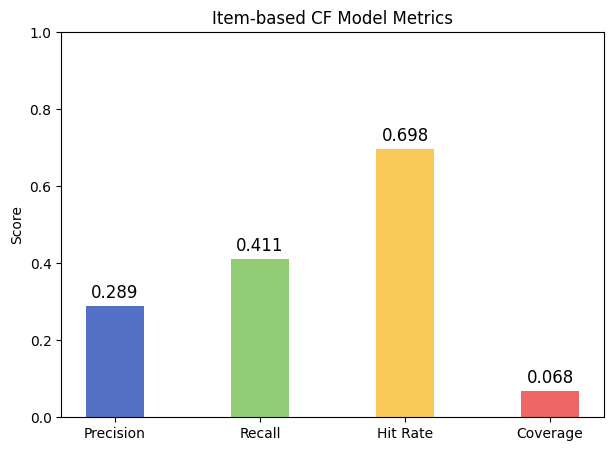

In [ ]:
import matplotlib.pyplot as plt

metrics = ['Precision', 'Recall', 'Hit Rate', 'Coverage']
values = [avg_precision, avg_recall, avg_hit_rate, coverage]

plt.figure(figsize=(7, 5))
bars = plt.bar(metrics, values, width=0.4, color=['#5470c6', '#91cc75', '#fac858', '#ee6666'])

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f"{value:.3f}", ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1)
plt.title("Item-based CF Model Metrics")
plt.ylabel("Score")
plt.show()

## User-Based Colaborative Filtering

In [ ]:
import json
import pandas as pd

file_path = "/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/Colaborative Filtering Data/user_based_cf_data.json"
with open(file_path, "r") as f:
    user_ratings = json.loads(f.readline())

records = []
for user_id, rec_list in user_ratings.items():
    for recipe_id, rating in rec_list:
        records.append({
            'user_id': str(user_id),
            'recipe_id': str(recipe_id),
            'rating': float(rating)
        })

df = pd.DataFrame(records)
print(df.head(100))


   user_id recipe_id  rating
0     16.0    7375.0     5.0
1     16.0    8887.0     5.0
2     16.0    9413.0     4.0
3     16.0    9584.0     5.0
4     16.0    9893.0     5.0
..     ...       ...     ...
95    39.0   12033.0     4.0
96    39.0   12072.0     4.0
97    39.0   12154.0     5.0
98    39.0   12409.0     5.0
99    39.0   12419.0     5.0

[100 rows x 3 columns]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np

#  STEP 1: Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# STEP 2: Map IDs to Integers
user_mapping = {u: i for i, u in enumerate(df['user_id'].unique())}
item_mapping = {i: j for j, i in enumerate(df['recipe_id'].unique())}

user_mapping_inv = {i: u for u, i in user_mapping.items()}
item_mapping_inv = {j: i for i, j in item_mapping.items()}

# Apply mapping
train_user_ids = train_df['user_id'].map(user_mapping)
train_item_ids = train_df['recipe_id'].map(item_mapping)

# STEP 3: Create Sparse User-Item Matrix
user_item_sparse = csr_matrix(
    (train_df['rating'], (train_user_ids, train_item_ids)),
    shape=(len(user_mapping), len(item_mapping))
)

# STEP 4: Compute User Similarity (Sparse) ======
print("Computing cosine similarity between users...")
user_similarity = cosine_similarity(user_item_sparse, dense_output=False)

#STEP 5: Predict Rating for a User-Item ======
def predict_rating(user_id, item_id, k=10, min_rating=1.0, max_rating=5.0):
    """Predict rating for given user and item using top-k similar users with normalization."""
    if (user_id not in user_mapping) or (item_id not in item_mapping):
        return np.nan

    user_idx = user_mapping[user_id]
    item_idx = item_mapping[item_id]

    sim_scores = user_similarity[user_idx].toarray().flatten()
    item_ratings = user_item_sparse[:, item_idx].toarray().flatten()

    mask = item_ratings > 0
    if not np.any(mask):
        return np.nan

    # Select top-k similar users who rated the item
    similar_users = np.argsort(sim_scores[mask])[::-1]
    top_users = np.where(mask)[0][similar_users][:k]

    top_sims = sim_scores[top_users]
    top_ratings = item_ratings[top_users]

    if np.sum(np.abs(top_sims)) == 0:
        return np.nan

    # Mean-centering for normalization
    user_mean = user_item_sparse[user_idx].toarray().flatten()
    user_mean = user_mean[user_mean > 0].mean() if np.any(user_mean > 0) else (max_rating + min_rating) / 2

    top_user_means = []
    for u in top_users:
        ratings_u = user_item_sparse[u].toarray().flatten()
        mean_u = ratings_u[ratings_u > 0].mean() if np.any(ratings_u > 0) else (max_rating + min_rating) / 2
        top_user_means.append(mean_u)

    top_user_means = np.array(top_user_means)

    # Adjusted weighted sum
    pred = user_mean + (np.dot(top_sims, top_ratings - top_user_means) / np.sum(np.abs(top_sims)))

    # Clip to rating scale
    return np.clip(pred, min_rating, max_rating)


#STEP 6: Evaluate Model with RMSE
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = ~np.isnan(y_pred)
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

print("Evaluating model...")
y_true, y_pred = [], []
for _, row in test_df.sample(5000, random_state=42).iterrows():  # sample for speed
    y_true.append(row['rating'])
    y_pred.append(predict_rating(row['user_id'], row['recipe_id'], k=10))

print("RMSE:", rmse(y_true, y_pred))

#STEP 7: Recommend Top-N Items for a User
def recommend_items(user_id, n=5, k=10):
    """Recommend top-n items for a given user based on user similarity."""
    if user_id not in user_mapping:
        return []

    user_idx = user_mapping[user_id]

    # Get items already rated by the user
    rated_items = user_item_sparse[user_idx].toarray().flatten() > 0

    predictions = []
    for item_idx in range(len(item_mapping)):
        if rated_items[item_idx]:
            continue  # skip already rated items
        pred = predict_rating(user_id, item_mapping_inv[item_idx], k=k)
        if not np.isnan(pred):
            predictions.append((item_mapping_inv[item_idx], pred))

    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

# Get recommendations for a user
example_user = df['user_id'].iloc[0]
print(f"\nTop 5 recommendations for user {example_user}:")
for recipe, score in recommend_items(example_user, n=5, k=10):
    print(f"Recipe: {recipe}, Predicted Rating: {score:.2f}")


Computing cosine similarity between users...
Evaluating model...
RMSE: 0.9093278314116472

Top 5 recommendations for user 16.0:
Recipe: 10702.0, Predicted Rating: 5.00
Recipe: 16699.0, Predicted Rating: 5.00
Recipe: 8589.0, Predicted Rating: 5.00
Recipe: 8623.0, Predicted Rating: 5.00
Recipe: 10638.0, Predicted Rating: 5.00


Faster predictor for metrics evaluation

In [ ]:
import random
from collections import defaultdict

_user_sim_cache = {}
_item_col_cache = {}
_user_mean_cache = {}
_user_row_cache = {}

def _get_user_sim_row(u_idx):
    row = _user_sim_cache.get(u_idx)
    if row is None:
        row = user_similarity[u_idx].toarray().ravel()
        _user_sim_cache[u_idx] = row
    return row

def _get_item_col(it_idx):
    col = _item_col_cache.get(it_idx)
    if col is None:
        col = user_item_sparse[:, it_idx].toarray().ravel()
        _item_col_cache[it_idx] = col
    return col

def _get_user_row(u_idx):
    row = _user_row_cache.get(u_idx)
    if row is None:
        row = user_item_sparse[u_idx].toarray().ravel()
        _user_row_cache[u_idx] = row
    return row

def _get_user_mean(u_idx, min_rating=1.0, max_rating=5.0):
    m = _user_mean_cache.get(u_idx)
    if m is None:
        r = _get_user_row(u_idx)
        m = r[r > 0].mean() if np.any(r > 0) else (min_rating + max_rating) / 2
        _user_mean_cache[u_idx] = m
    return m


# Fast cached predictor
def predict_rating_cached(user_id, item_id, k=10, min_rating=1.0, max_rating=5.0):
    if (user_id not in user_mapping) or (item_id not in item_mapping):
        return np.nan

    u_idx = user_mapping[user_id]
    it_idx = item_mapping[item_id]

    sim_scores = _get_user_sim_row(u_idx)
    item_ratings = _get_item_col(it_idx)

    mask = item_ratings > 0
    if not np.any(mask):
        return np.nan

    # top-k similar raters of this item
    # (sort only masked similarities)
    masked_sims = sim_scores[mask]
    rated_user_idxs = np.where(mask)[0]
    order = np.argsort(masked_sims)[::-1]
    top_users = rated_user_idxs[order][:k]

    top_sims = sim_scores[top_users]
    top_ratings = item_ratings[top_users]

    denom = np.sum(np.abs(top_sims))
    if denom == 0:
        return np.nan

    user_mean = _get_user_mean(u_idx, min_rating, max_rating)

    # means of neighbors
    top_user_means = np.array([_get_user_mean(u, min_rating, max_rating) for u in top_users])

    pred = user_mean + (np.dot(top_sims, top_ratings - top_user_means) / denom)
    return float(np.clip(pred, min_rating, max_rating))



# Pointwise metrics (RMSE, MAE)
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = ~np.isnan(y_pred)
    return float(np.sqrt(np.mean((y_true[mask] - y_pred[mask])**2))) if np.any(mask) else np.nan

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = ~np.isnan(y_pred)
    return float(np.mean(np.abs(y_true[mask] - y_pred[mask]))) if np.any(mask) else np.nan



#sample candidates (negatives) efficiently
_all_items = np.array(list(item_mapping.keys()))
_all_items_idx = np.array(list(item_mapping.values()))

def _get_user_rated_item_idxs(u_idx):
    row = _get_user_row(u_idx)
    return np.where(row > 0)[0]

def _sample_candidates_for_user(u_idx, positives_item_ids, n_negatives=200):
    """Return candidate item_ids = positives ∪ sampled negatives (unrated)."""
    rated_item_idxs = set(_get_user_rated_item_idxs(u_idx))
    # Mask unrated
    unrated_mask = np.ones_like(_all_items_idx, dtype=bool)
    if rated_item_idxs:
        unrated_mask[list(rated_item_idxs)] = False
    unrated_items = _all_items[unrated_mask]

    # sample negatives (avoiding tiny pools)
    n = min(n_negatives, len(unrated_items))
    if n > 0:
        neg_sample = np.random.choice(unrated_items, size=n, replace=False)
        candidates = set(neg_sample)
    else:
        candidates = set()

    candidates.update(positives_item_ids)
    return list(candidates)


# Ranking metrics using candidate sampling (fast, scalable)
def precision_recall_ndcg_at_k_sampled(
    test_df,
    k=5,
    user_sample=200,
    negatives_per_user=200,
    seed=42
):
    rng = random.Random(seed)
    np.random.seed(seed)

    # actual items in test per user
    test_pos = test_df.groupby('user_id')['recipe_id'].apply(set).to_dict()

    users_all = list(test_pos.keys())
    rng.shuffle(users_all)
    users_eval = users_all[:min(user_sample, len(users_all))]

    precisions = []
    recalls = []
    ndcgs = []

    def dcg_binary(relevance):
        # relevance is a list of 0/1 in ranked order
        idx = np.arange(2, len(relevance) + 2)
        return float(np.sum((2**np.array(relevance) - 1) / np.log2(idx)))

    for user_id in users_eval:
        if user_id not in user_mapping:
            continue
        u_idx = user_mapping[user_id]

        positives = list(test_pos.get(user_id, set()))
        if not positives:
            continue

        # Build candidate pool: test positives + sampled negatives
        candidates = _sample_candidates_for_user(u_idx, positives, n_negatives=negatives_per_user)

        # Score candidates
        scored = []
        for item_id in candidates:
            p = predict_rating_cached(user_id, item_id, k=k)
            if not np.isnan(p):
                scored.append((item_id, p))

        if not scored:
            continue

        scored.sort(key=lambda x: x[1], reverse=True)
        topk = [iid for iid, _ in scored[:k]]

        # Precision@k
        hits = sum(1 for iid in topk if iid in positives)
        precisions.append(hits / k)

        # Recall@k
        recalls.append(hits / len(positives))

        # NDCG@k (binary relevance)
        rel = [1 if iid in positives else 0 for iid in topk]
        ideal_rel = sorted([1]*min(k, len(positives)) + [0]*(k - min(k, len(positives))), reverse=True)
        denom = dcg_binary(ideal_rel)
        ndcgs.append(dcg_binary(rel) / denom if denom > 0 else 0.0)

    # Safe means
    P = float(np.mean(precisions)) if precisions else 0.0
    R = float(np.mean(recalls)) if recalls else 0.0
    N = float(np.mean(ndcgs)) if ndcgs else 0.0
    return P, R, N

# End-to-end: run all metrics on random subsamples

def evaluate_all_metrics_fast(
    test_df,
    pointwise_sample=1000,
    k=5,
    user_sample=200,
    negatives_per_user=200,
    seed=42
):
    random.seed(seed)
    np.random.seed(seed)

    # --- Pointwise (RMSE/MAE) on a random subset of rows
    sample_df = test_df.sample(min(pointwise_sample, len(test_df)), random_state=seed)
    y_true, y_pred = [], []
    for _, row in sample_df.iterrows():
        y_true.append(row['rating'])
        y_pred.append(predict_rating_cached(row['user_id'], row['recipe_id'], k=k))
    rmse_val = rmse(y_true, y_pred)
    mae_val = mae(y_true, y_pred)

    # --- Ranking metrics with candidate sampling
    prec, rec, ndcg = precision_recall_ndcg_at_k_sampled(
        test_df,
        k=k,
        user_sample=user_sample,
        negatives_per_user=negatives_per_user,
        seed=seed
    )

    print(f"RMSE (sample {len(sample_df)}): {rmse_val:.4f}")
    print(f"MAE  (sample {len(sample_df)}): {mae_val:.4f}")
    print(f"Precision@{k} (users {user_sample}, neg/user {negatives_per_user}): {prec:.4f}")
    print(f"Recall@{k}    (users {user_sample}, neg/user {negatives_per_user}): {rec:.4f}")
    print(f"NDCG@{k}      (users {user_sample}, neg/user {negatives_per_user}): {ndcg:.4f}")

evaluate_all_metrics_fast(test_df, pointwise_sample=20000, k=5, user_sample=10000, negatives_per_user=300)

RMSE (sample 20000): 0.9454
MAE  (sample 20000): 0.6398
Precision@5 (users 10000, neg/user 300): 0.0074
Recall@5    (users 10000, neg/user 300): 0.0214
NDCG@5      (users 10000, neg/user 300): 0.0142


## Combined Model

Firstly, let's recap what we have done so far:

1. Content-based model: We have created a model that given a specific recipe, it will find similar recipes.
2. User-based model: Given a specific user, the model recommends recipes similar users have liked before.
3. Item-based model: Given a specific recipe, the model finds similar recipes based on any overlapping users who interacted with both recipes.

Now that we have the three models ready, we can create the overall model, which takes the strengths of all three models. To sum up, we have come up with two ways on how to combine them:

1. Getting independent results from each model: This is the simpler approach of the two. Bascially, we get the top recommendations from each model and combine them together. For now, we have decided to have 50% of recipes from the content-based model, 30% from user-based model and 20% from item-based model. This would allow us to have both similar recipes from user's historical data, whilst also providing new recipes they might like from the collaborative filtering models.

2. Aggregating the scores from each model for each recipe: For each of the model, we can provide a score from 0 to 1 for every recipe. Then, we can aggregate the scores together and recommend the top K recipes with the highest aggregated scores.

We have decided to go with the first way because aggregating the score would mean results that are mediocre in both relevance and diversity, since the scores are pretty much 'averaged'. Returning the best results from each model would give results that are either the most relevant, or the best recipes for them to try out.

#### Input:
For each user, they would have liked some recipes before (either initially for cold start or during run-time when they are using the app). We only need those data for all of the three models.

#### Output:
- 50% of results would come from content-based model.
- 30% of results would come from user-based model.
- 20% of results would come from item-based model.

In terms of evaluation, we have all separately evaluated the effectiveness of each of the model separately. Unfortunately, due to RAM issues and Colab quota, we weren't able to run the evaluation function below (`eval_combined_model` function). Basically, we use past user ratings to evaluate the effectiveness of our model with the following steps:

1. We sample 100 users. What we get for each user would be a list of recipe-rating pairs, indicating what rating (out of 5) they gave for that recipe.
2. Then, for each user we obtain the top-k recommendations from our combined model. We will test for different top-k values to see what works best. Also, to align with our app, our top-k values would be quite small, since we can't actually show that many results, nor would the user spend a lot of time scrolling through hundreds, or even thousands of recipes.
3. For each of the recommended recipe, we first check if the user has given it a rating. If the user has indeed rated it and has given it a 5-star, it is a true positive, otherwise it is a false positive. The reason why we set everything below a 5 out of 5 rating to be a false positive is because most ratings are 5 out of 5 (around 65%). This also aligns with the fact that there is usually a bias, where people are most likely to rate only if they like a recipe. For non-rated recipes, we also treat it as a false positive.


In [ ]:
# Weights for different models
content_weight = 0.5
user_weight = 0.3
item_weight = 0.2

def get_combined_model_recommendations(user_id, liked_recipes, ratings, top_k=10):
  '''
  Args:
  - user_id
  - liked_recipes: a list of recipe_ids the user liked or picked initially
  - ratings: a list of (recipe_id, rating) pairs to represent what ratings (out of 5) the user rated the recipe

  IMPORTANT: Note that the results of each model could be of different types (needs fixing)
  '''
  # How many items we want for each model
  num_user = int(top_k * user_weight)
  num_item = int(top_k * item_weight)
  num_content = top_k - num_user - num_item   # To make sure we always get top k items

  results = []

  # We need to unify the outputs to be a list of recipe_id
  results.extend(get_content_based_recommendation(liked_recipes, top_k=num_content)) # content-based
  results.extend(recommend_items(user_id, n=num_user))  # user-based
  results.extend(get_item_recommendations(liked_recipes, num_item=num_item))

  return results




In [ ]:
import json
import random

# We can use ECDF (Empirical Cumulative Distribution Function) to scale ratings
ecdf_map = {1.0: 0.0062, 1.5: 0.0065, 2.0: 0.0141, 2.5: 0.0166, 3.0: 0.0506, 3.5: 0.0654, 4.0: 0.2244, 4.5: 0.3519, 5.0: 1.0}

# Just sub in your model and it'll spit out evaluation
def eval_combined_model():
  '''
  For simplicity, this function prints your output out as lists (e.g. precision, recall)
  If you want to graph them out just copy the printed outputs
  '''
  with open('/content/drive/MyDrive/Recipe Recommender System/Cleaned Data/Content-Based Data/userToRecipe&RatingList.json', 'r') as f:
      reviews = json.load(f)  # user_id: [[recipe_id, rating]]

  # We only want users with more than five 5-star ratings
  users = [
      (user_id, [(recipe_id, rating) for recipe_id, rating in ratings])
      for user_id, ratings in reviews.items()
      if sum(1 for _, rating in ratings if rating == 5.0) >= 5
  ]

  # Randomly sample 100 users
  sample_users = random.sample(users, 100)

  print(f"There should be 100 sample users now: len(sample_users) = {len(sample_users)}")
  print(f"Example user: {users[0]}")

  # Swtich your method here - I have combined_model here but feel free to switch to any
  precisions, recalls, ecdf_scores, ecdf_all_scores = [], [], [], []

  for top_k in range(5, 25, 5):
    for user in users:
      user_id, ratings = user
      liked_recipes = [recipe_id for recipe_id, rating in ratings if rating == 5.0]

      results = get_combined_model_recommendations(user_id, liked_recipes, ratings, top_k=top_k)

      true_pos, false_pos, false_neg = 0, 0, 0
      ecdf_score, ecdf_cnt, ecdf_all_cnt = 0.0, 0, 0
      for recipe_id, rating in ratings:
        if recipe_id in results:
          if rating == 5.0:
            true_pos += 1
          else:
            false_pos += 1
          ecdf_score += ecdf_map[rating]
          ecdf_cnt += 1
        else:
          if rating == 5.0:
            false_neg += 1
          ecdf_all_cnt += 1

      precision = true_pos / (true_pos + false_pos) if true_pos + false_pos > 0 else 0.0
      recall = true_pos / (true_pos + false_neg) if true_pos + false_neg > 0 else 0.0

      precisions.append(precision)
      recalls.append(recall)
      ecdf_scores.append(ecdf_score / ecdf_cnt if ecdf_cnt else 0.0)
      ecdf_all_scores.append(ecdf_score / ecdf_all_cnt if ecdf_all_cnt else 0.0)

  print(f"Precisions: {precisions}")
  print(f"Recalls: {recalls}")
  print(f"ECDF Scores: {ecdf_scores}")
  print(f"ECDF All Scores: {ecdf_all_scores}")

# This is for testing combined model
# eval_combined_model()
